# Covid 19 : India Analysis and Forecasting
TO DO <br>
have 2 sections :
1. Statistics & Mathematical Metrics.
- Nationwide Stats.
- State-wise stats with a selector for selecting States.
2. Predictions
- Feature Engineering.
- Modelling, predictions - both models.

## Note: 
<p> The author doesn't claim to have any domain knowledge and isn't an epidemiologist. The analysis in this notebook is just an attempt to learn new techniques and gather potential insights from the available data but shouldn't be taken seriously. </p>

In [36]:
from plotly.offline import init_notebook_mode
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from matplotlib import dates as dt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.exceptions import NotFittedError
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import seasonal, stattools, arima_model, stattools, statespace
from statsmodels.tsa.statespace import sarimax
from IPython.display import display
from xgboost import XGBRegressor

# For suppressing statsmodels warnings.
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

plt.style.use('seaborn')
init_notebook_mode(connected=True)

# 1. Grabbing Data
TO DO :
1. Move helper functions to Utils. 
2. See if you can grab updated WW data.

### A. Using Kaggle Challenge Dataset 
Stored Locally.

In [933]:
path_train = 'covid19-global-forecasting-week-4/train.csv'
path_test = 'covid19-global-forecasting-week-4/test.csv'
path_sbumit = 'covid19-global-forecasting-week-2/submission.csv'

train_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/train.csv'
test_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/test.csv'
submit_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/submission.csv'

path_graphs = 'Graphs/'

In [2]:
df_train_count = pd.read_csv(path_train)
df_test_count = pd.read_csv(path_test)
df_train_count.rename(columns={'Country_Region': 'Country/Region',
                               'Province_State': 'Province/State'}, inplace=True)
df_test_count.rename(columns={'Country_Region': 'Country/Region',
                              'Province_State': 'Province/State'}, inplace=True)

NameError: name 'path_train' is not defined

#### Helper Functions For Kaggle Dataset : 1. To filter DataFrame according to Country.

In [4]:
def country_df(country, df):
    """Filters a Dataframe according to Country.
    Args: 
    country: String. Name of country for which dataframe is to be filtered for.
    df: Dataframe. The Dataframe that is to be filtered.
    Returns: 
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    """
    if country != 'World':
        country_filt = (df['Country/Region'] == country)
        df_cases = df.loc[country_filt].groupby(
            ['Date'])['ConfirmedCases'].sum()
        df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    else:
        df_cases = df.groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.groupby(['Date'])['Fatalities'].sum()

    return df_cases, df_fatal

#### 2. To Prepare Model Train data.

In [5]:
def prepare_train_data(df_cases, df_fatal):
    """Splits ConfirmedCases and Fatalities dataframe into training features and labels.
    Args:
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    Returns:
    x_train: np array. Array of integers denoting days since firstday of original df for model training features.
    y_cases: List. List of Confirmed Cases as labels for model from first day of original df.
    y_fatal: List. List of Fatalities as labels for model from first day of original df.
    """
    x_train = np.arange(0, len(df_cases)).reshape(-1, 1)
    y_cases = df_cases.to_list()
    y_fatal = df_fatal.to_list()

    return x_train, y_cases, y_fatal

#### 3. For Plotting Actual and Predicted Metrics after modelling.

In [507]:
def plot_actual_predicted(country, label,  y_cases, y_pred, show_lockdown=False, start_date='2020-01-22'):
    """Plots the Actual and Predicted ConfirmedCases/Fatalities for a country.
    Args:
    country(string) country name.
    y_cases, y_pred (array/list) - Actual And Predicted Metrics.
    label(string) - Which metric is being passed.
    Returns:
    """

    xtick_locator = AutoDateLocator()
    xtick_formatter = AutoDateFormatter(xtick_locator)

    # generating dates using pandas, can be used with date_plot.
    train_times = pd.date_range(start=start_date, periods=len(y_cases))
    test_times = pd.date_range(start=start_date, periods=len(y_pred))
    dates = train_times.to_series().dt.date
    dates_test = test_times.to_series().dt.date

    # converting to Series, list
    d_train = dates.tolist()
    d_test = dates_test.tolist()

    # getting date_format variable for matplotlib and lockdown date.
    date_format = dt.DateFormatter('%b, %d')

    # converting lockdown date string to datetime.
    lockdown_date_str = '2020-03-25'
    lockdown_date = datetime.datetime.strptime(lockdown_date_str, '%Y-%m-%d')

    plt.style.use('seaborn')
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(17)
    fig.autofmt_xdate()
    ax.plot_date(d_train, y_cases, label='Actual Values',
                 linestyle='solid', marker=None)
    ax.plot_date(d_test, y_pred, label='Predicted Values',
                 linestyle='solid', marker=None)
    ax.set_title(
        f'{country} : {label}')
    ax.set_ylabel(f'No of {label}')
    if show_lockdown:
        ax.plot_date([lockdown_date, lockdown_date],
                     plt.gca().get_ylim(), 'r-', label='Lockdown')
    ax.xaxis.set_major_formatter(date_format)
    ax.legend()
    #fig.savefig( path_graphs + f'{country}_conf_case.jpg')

### B. Getting Data Using Covid19India.org API
Fetches JSON from the Covid19.org API and creates dataframe of Daily and Total Cases, Recovered, Deceased.<br>
Testing data from Datameet ICMR backup JSON.

In [2]:
from Data.india_API_data.Covid19_india_org_api import make_dataframe
from Data.india_API_data.Covid19_india_org_api import get_test_dataframe

In [3]:
from urllib.request import urlopen

### C. Grabbing Data from SQLite DB
Uses the data grabbed from B. which has been stored in a SQLite database to avoid repeatedly fetching data from the API. Data may not be latest. Run Ingest_to_DB.py as a script to get latest data into database or Function can fetch new data using parameter fetch_new = Bool. Default table name 'covid'. 

In [4]:
from Data.india_API_data.Ingest_to_DB import data_to_df

### D. Grabbing Data from Local SQL Server/CloudSQl server

#### Helper Functions For API Data : 1. Plotting Metrics

In [10]:
def plot_daily(df, columns, save=False, log=False):
    """ Helper Function to Plot Current Metrics from API data.
    Args: 
    df (Dataframe) - Dataframe of API data create Using Make_dataframe.
    columns (List of column names)
    save(Bool) - Whether to save fig.
    Returns:
    """
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    plt.style.use('seaborn')
    plt.title('Daily Trends: India (From API)')
    plt.ylabel('No. Of Individuals')
    plt.xlabel('Date')
    fig.autofmt_xdate()
    for item in columns:
        plt.plot_date(x=df.index, y=df[item],
                      label=item, linestyle='solid', marker=None)
    plt.legend()
    if save == True:
        fig.savefig(path_graphs + save + 'India_Cumulative_stats.png')
    if log == True:
        plt.yscale('log')
        plt.title('Daily Trends(Log): India (From API)')
    plt.show()

# 2. Visualizations & Analysis


## Logistic Curve or S- shaped Curve : Modeling Epidemic Behaviour
<p>From the 3blue1brown video, epidemics are observed to follow a logistic curve. The no. of infected rises exponentially and reaches an inflection point before gradually decreasing. This can be somewhat seen in China's Confirmed Cases plot.</p>
$$f{(x)} = \frac{L}{1 + e^{-k(x - x_0)}}$$
Here x0 = the x value of the sigmoids' midpoint. <br>
L = the curve's maximum value. <br>
k = the logistic growth rate or steepness of the curve. <br>
Resource :
https://www.maa.org/book/export/html/115630

In [3]:
from plotly.subplots import make_subplots

In [12]:
pd.options.plotting.backend = 'plotly'

In [13]:
def log_epidemic_comp(china_cases_df):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Simple Logistic Curve",
                                        "China cumulative Cases"),
                        vertical_spacing=.1)

    # Plotting a simple logistic curve using numpy and matplotlib.
    # x = (-6,6), L =1, k = 1, x0 =0
    x = np.arange(-6, 7)
    power = -1*x
    y = 1 / (1 + np.exp(power))
    fig_1 = px.line(x = x, y = y)
    fig_1['data'][0].showlegend = False
    fig.append_trace(fig_1['data'][0], 1, 1)

    # Cases for china 
    fig_2 = china_cases_df.plot()
    fig_2['data'][0].showlegend = False
    fig.append_trace(fig_2['data'][0], 1, 2)

    # Updating Axis Titles

    fig.update_yaxes(title_text=r"$f{(x)}$", row=1, col=1)
    fig.update_xaxes(title_text=r"$x$", row=1, col=1)

    fig.update_yaxes(title_text="Confirmed Cases", row=1, col=2)
    fig.update_xaxes(title_text="Date", row=1, col=2)

    # figure specs.
    fig.update_layout(title_text="Modelling Epidemic Behaviour")
    return fig

In [14]:
china_cases, china_fatal = country_df('China', df_train_count)
log_epidemic_comp(china_cases)

##### Curve fitting using scipy.optimize - uses non-linear least squares to fit a function to data
<p>From the 3blue1brown video, epidemics are observed to follow a logistic curve. The no. of infected rises exponentially and reaches an inflection point before gradually decreasing. This can be somewhat seen in China's Confirmed Cases plot.</p>
$$f{(x)} = \frac{L}{1 + e^{-k(x - x_0)}}$$
Here x0 = the x value of the sigmoids' midpoint. <br>
L = the curve's maximum value. <br>
k = the logistic growth rate or steepness of the curve. <br>

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.estimator_checks import check_estimator

# curve fit function from scipy.optimize to fit a function using nonlinear least squares.
from scipy.optimize import curve_fit

In [5]:
class SigmoidCurveFit(BaseEstimator, RegressorMixin):
    """Sklearn Wrapper to fit a General Logistic curve of the form $f{(x)} = \frac{L}{1 + e^{-k(x - x_0)}}$.
    Where x_0 = the value of the sigmoids' midpoint.
          L = the curve's maximum value.
          k = the logistic growth rate or steepness of the curve.
    The parameters aer returned in the popt variable after fitting the sigmoid.
    """
    
    def __init__(self,fit_intercept=True):
        self.fit_intercept = fit_intercept
        # to check if model has been fit, will not be none after fit
        self.popt = None

    def sigmoid(self,x, L,x0, k):
        return L / (1 + np.exp(-k*(x-x0)))
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # need to be flattenned again as scipy curve fit takes flat 1-D array
        self.X_ = np.ravel(X)
        self.y_ = y
        
        # fit parameters and covariance matrix
        self.popt, self.pcov = curve_fit(self.sigmoid, self.X_, self.y_)
        
    def predict(self, X):
        # Check is fit had been called
        if self.popt is None:
            check_is_fitted(self, 'model_')
        return self.sigmoid(X, *self.popt)
    def get_sigmoid_params(self):
        # Check is fit had been called
        if self.popt is None:
            check_is_fitted(self, 'model_')
        return {'L' : self.popt[0], 'x0': self.popt[1], 'k':self.popt[2]}

In [5]:
# india_data is defined later. 
india_data = data_to_df('covid', fetch_new=True)
india_data.date = pd.to_datetime(india_data.date)
india_data.set_index('date', inplace=True)
india_data = india_data.astype('float')

# output is the number of cumulative/total cases
# Input - days since first reported case, 2020-01-30

x_data = np.arange(len(india_data['TotalConfirmed']))

y_data = india_data['TotalConfirmed'].values

Table Exists With 245 Records
Added 1 Records


In [7]:
# splitting into train and test(last 30 days) without shuffling.
index = 30
x_train = x_data[:-index]
x_test = x_data[-index:]
y_train = y_data[:-index]
y_test = y_data[-index:]

# creating a sigmoid curve fit object

sigmoid = SigmoidCurveFit()

sigmoid.fit(x_train.reshape(-1,1), y_train)
print(f'R^2 : {sigmoid.score(x_test, y_test)}, Mean absolute error : {mean_absolute_error(y_test,sigmoid.predict(x_test) )}')

R^2 : 0.8378266265508177, Mean absolute error : 228637.84713960785


In [8]:
sigmoid.get_sigmoid_params()

{'L': 6808714.316342977, 'x0': 210.1525411672086, 'k': 0.04091459969765396}

In [9]:
preds = sigmoid.predict(x_data.reshape(-1,1))

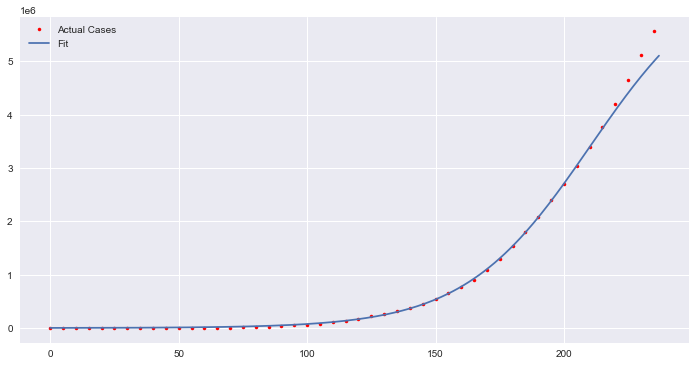

In [10]:
# check fit - overestimates the cases.
plt.figure(figsize=(12, 6))
#plt.xlim(170, 200)
plt.plot(x_data[::5], y_data[::5],'r.', label = 'Actual Cases')
plt.plot(x_data, preds, label = 'Fit')
plt.legend()
plt.show()

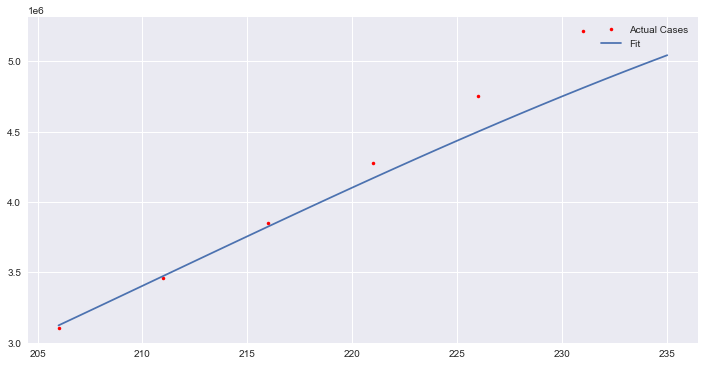

In [1006]:
# check validation set perf.

preds = sigmoid.predict(x_test.reshape(-1,1))


plt.figure(figsize=(12, 6))
#plt.xlim(170, 200)
plt.plot(x_test[::5], y_test[::5],'r.', label = 'Actual Cases')
plt.plot(x_test, preds, label = 'Fit')
plt.legend()
plt.show()

In [942]:
x_test[1:].shape

(29,)

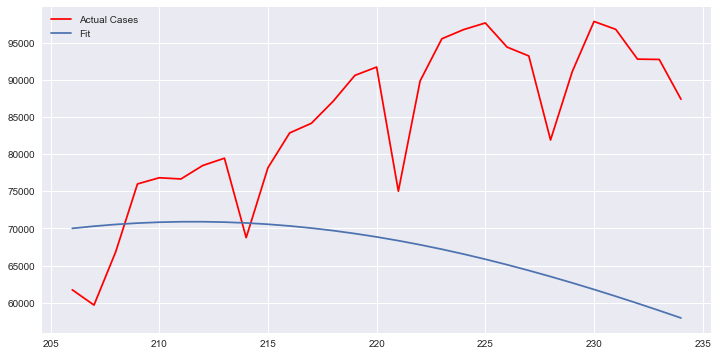

In [943]:
# daily predictions
plt.figure(figsize=(12, 6))
#plt.xlim(170, 200)
plt.plot(x_test[1:], np.diff(y_test, n=1),'r', label = 'Actual Cases')
plt.plot(x_test[1:], np.diff(preds.ravel(), n=1), label = 'Fit')
plt.legend()
plt.show()

In [222]:
fig = px.line(x = x_test[1:],y=  np.diff(y_test, n=1), title = 'Actual Cases')
fig.add_scatter(x = x_test[1:],y =  np.diff(preds.ravel(), n=1), mode = 'lines')

In [232]:
# so, from the fitted/learned paramters
# L the curve's maximum value.  ,x0 value of the logistic functions mid point,
# k - the logistic growth rate or steepness of the curve. So, 
print(f'Max Number of Cases (peak of curve) : {int(sigmoid.popt[0])},\n\
Mid point of the curve reached on day : {int(sigmoid.popt[1])},\n\
Logistic curve growth rate {sigmoid.popt[2]}')

Max Number of Cases (peak of curve) : 8004739,
Mid point of the curve reached on day : 216,
Logistic curve growth rate 0.03986190133933291


In [ ]:
# lets plot a single graph with shaded training area, validation area and predictions.
# Another div with the performance metrics, and fit paramters.

In [ ]:
# first create a data frame with the valid dates and add 

In [84]:
# make everything other than every 5th value nan
df = india_data.copy()
df['TotalConfirmed'][~df.index.isin(df[::5].index)] = np.nan

In [207]:
# for entire input
preds = sigmoid.predict(np.arange(len(x_data) + z).reshape(-1,1)).ravel()

In [208]:
pd.options.plotting.backend = 'plotly'

fig = df['TotalConfirmed'].plot(title='Logistic Curve fit to Cumulative Cases',kind='scatter')
#fig.update_layout()
fig.add_scatter(x = df.index, y = preds.ravel())
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= df.index[-30], x1= df.index[-30]
    )
])
fig.show()

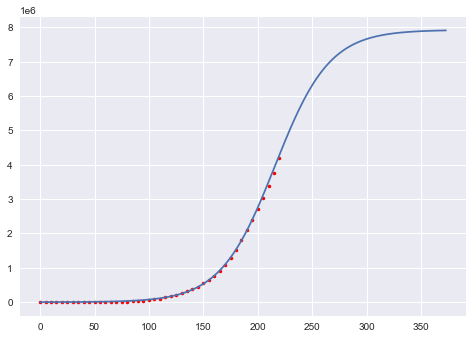

In [111]:
# predicting for next 150 days
z = 150
plt.plot(x_data[::5], y_data[::5],'r.', label = 'Actual Cases')
plt.plot(np.arange(len(x_data) + z), sigmoid.predict(np.arange(len(x_data) + z).reshape(-1,1)), label = 'Fit')

## Worlwide Cases

In [14]:
world_cases, world_fatal = country_df('World', df_train_count)
world_cases.plot(title = 'Worldwide Confirmed Cases')

In [15]:
fig = world_cases.plot(title = 'Worldwide Confirmed Cases (Log)')
fig.update_layout(yaxis_type="log")
fig.show()

1. The Number of People getting infected is still growing, but to check whether it is growing exponentially we have to use the log scale.
2. The data plotted on the log Scale shows that the growth Seems to be touching the green line representing exponential growth. This could be a temporary Dip Before another wave and does not guarantee that the inflection point of the initial exponential growth has been reached.

## India - Current Statistics

In [8]:
#india_data = make_dataframe()
india_data = data_to_df('covid', fetch_new=True)
india_data.date = pd.to_datetime(india_data.date)
india_data.set_index('date', inplace=True)
india_data = india_data.astype('float')

Table Exists With 227 Records
Added 0 Records


In [9]:
pd.options.plotting.backend = "plotly"
fig_1 = india_data[['DailyConfirmed', 'DailyDeceased',
                  'DailyRecovered']].iloc[40:].plot(title=' Daily Trends: India')
fig_1.update_layout(yaxis=dict(title='Number of Patients'),
                  legend_title_text='Statistic', legend=dict(x=.85, y=1.24))

In [167]:
fig_2 = india_data[['DailyConfirmed', 'DailyDeceased',
                  'DailyRecovered']].rolling(window=7).mean().iloc[40:].plot(title=' 7 Day Moving Average : India')
fig_2.update_layout(yaxis=dict(title='Number of Patients'),
                  legend_title_text='Statistic', legend=dict(x=.85, y=1.24))

In [169]:
fig_3 = india_data[['TotalConfirmed', 'TotalDeceased',
                  'TotalRecovered']].iloc[40:].plot(title=' Cumulative Trend: India')
fig_3.update_layout(yaxis=dict(title='Number of Patients'),
                  legend_title_text='Statistic', legend=dict(x=.85, y=1.24))

### India Testing Statistics
The comparison of the graphs of the amount of Testing Done and the confirmed Cases each day can be a good indicator of whether enough testing is being done. If the curves are very close by it can indicate that not enough people are getting tested. Visualising the Daily confirmed cases and Testing Samples collected on a semi-log graph shows that the number of confirmed cases per day is increasing at a faster rate than the Testing Rate although this is understandably skewed due to the log axis. <br>
Looking at the comparison and observing the sharp increase in samples collected, we can say that testing is finally being done on a larger scale. (Testing Data from 03-13. Sharper increase in April). <br>
Also observe the weekly seasonality in testing samples collected.

In [170]:
fig = india_data[['TestingSamples']].iloc[40:].diff(
    1).plot(title=' Daily Testing Trends: India')
fig.update_layout(yaxis=dict(title='Number of Samples Tested'),
                  legend_title_text='No. of Testing Samples Collected per day by ICMR', legend=dict(x=.65, y=1.15))

In [171]:
fig = india_data[['TestingSamples', 'TotalConfirmed']].iloc[40:].diff(
    1).plot(title=' Daily Testing and New Cases : India')
fig.update_layout(yaxis=dict(title='Number of Samples Tested, Total Confirmed Cases '),
                  legend_title_text='Daily Stats', legend=dict(x=.85, y=1.15))

In [172]:
fig = india_data[['TestingSamples', 'TotalConfirmed']].iloc[40:].diff(
    1).plot(title=' Daily Testing and New Cases(Log) : India')
fig.update_layout(yaxis=dict(title='Number of Samples Tested, Total Confirmed Cases '),
                  legend_title_text='Daily Stats', yaxis_type="log", legend=dict(x=.85, y=1.15))

In [10]:
#plot_daily(india_combined_data, ['TotalConfirmed', 'Testing Samples'])#, save='Cofirmed_testing_samples_')

### Growth Factor (R Number ) Of Virus
<p>
    The growth factor on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.
     <br>Measure of whether the disease is growing or not. </p>
1. A value of greater than 1 = growth. <br>
2. Less than 1 = decline. <br>
3. A growth factor of 1 is the inflection point and at this point the disease is not increasing.

<p>
As of 24th April, it can be seen that the growth of the virus <b>hasn't stabilised at the inflection point but is much lower than the mean growth factor upto this point indicating that the initial exponential growth might be over. </b><br>
The Linear Regression on the Growth Factor seems to point to a downward trend in the Growth Factor but the margin of error is high.

In [457]:
def growth_factor(confirmed):
    confirmed_nminus1 = confirmed.shift(1, axis=0)
    confirmed_nminus2 = confirmed.shift(2, axis=0)
    return ((confirmed - confirmed_nminus1)/(confirmed_nminus1 - confirmed_nminus2))

In [458]:
india_growth_factor = growth_factor(india_data.TotalConfirmed[41:])
india_growth_factor.rename(index = 'Growth Factor', inplace=True)
print(f'Mean Growth Factor : {india_growth_factor.mean()}')
print(f'Mean Growth Factor of the last 10 days : {india_growth_factor[-10:].mean()}')

Mean Growth Factor : 1.0607260936593454
Mean Growth Factor of the last 10 days : 0.9966212188321671


In [245]:
pd.options.plotting.backend = 'plotly'

# overall growth factor
fig = india_growth_factor.plot(
    title='India Growth Factor Since 2020-03-11 (Widespread Testing) ')

# mean growth Factor
fig.add_scatter(y = [india_growth_factor.mean(), india_growth_factor.mean()],
             x = [india_growth_factor.index[0], india_growth_factor.index[-1]], mode='lines',
                name = f'Mean Growth Factor = {india_growth_factor.mean():.4f}',
                line = dict(
                color="crimson",
                width=4,
                dash="dashdot",
            ),
               )
# growth factor for last 10 days
fig.add_scatter(y = [india_growth_factor[-10:].mean(), india_growth_factor[-10:].mean()],
             x = [india_growth_factor.index[-10], india_growth_factor.index[-1]], mode='lines',
                name = f'Mean Growth Factor Last 10 days = {india_growth_factor[-10:].mean():.4f}',
                line = dict(
                color="lightseagreen",
                width=4,
                dash="dashdot",
            ),
               )
# Updating legend location
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
),legend_title_text='')

fig.show()

#### Linear Regression on Growth Factor.
This points to downwards trend, however due to not enough early testing there are outliers with very high growth rate. The confidence interval shows that a slight upwards curve is also possible, so the results need to be interpreted with caution. Removing the outliers resulted in a tighter confidence interval but have not been removed. Looking at the Residualplot, there appears to be an initial non-linear relationship between the growth factor and the time series of days since first case/data availability. This has been investigated later.

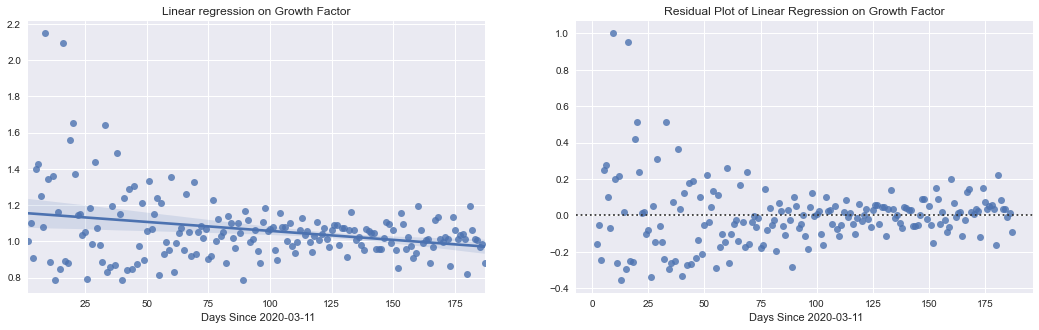

In [588]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.regplot(x=np.arange(len(india_growth_factor.index.tolist())),
            y=india_growth_factor.to_list(), ax=ax[0])
ax[0].set_title('Linear regression on Growth Factor')
ax[0].set_xlabel(' Days Since 2020-03-11')
sns.residplot(x=np.arange(len(india_growth_factor.index.tolist())),
              y=india_growth_factor.to_list(), ax=ax[1])
ax[1].set_title('Residual Plot of Linear Regression on Growth Factor')
ax[1].set_xlabel(' Days Since 2020-03-11')
#plt.savefig(path_graphs +'India_Growth_Factor_Pred')
plt.show()

##### Regression models on growth Factor

In [635]:
def growth_factor_features(gf_df):
    """All features should be available at inference time"""
    # creating lagged features 
    gf_df['Lag_1days'] = gf_df.shift(1)
    gf_df['Lag_2days'] = gf_df['Growth_Factor'].shift(2)
    gf_df['Lag_3days'] = gf_df['Growth_Factor'].shift(3)
    gf_df['Lag_4days'] = gf_df['Growth_Factor'].shift(4)
    gf_df['Lag_5days'] = gf_df['Growth_Factor'].shift(5)
    gf_df['Lag_6days'] = gf_df['Growth_Factor'].shift(6)
    gf_df['Lag_7days'] = gf_df['Growth_Factor'].shift(7)
    gf_df['Days_since_03-13'] = np.arange(len(gf_df.index.tolist()))
    # Add date features.
    gf_df['month'] = gf_df.index.month
    gf_df['day'] = gf_df.index.day
    gf_df['day_week'] = gf_df.index.dayofweek
    # differenced features 
    gf_df['Lag_1days_diff'] = gf_df['Lag_1days'].diff(1)
    return gf_df

In [10]:
def perf_adf(ts):
    """Performs ADF test on time series and prints Results.
    """
    dftest = stattools.adfuller(ts, maxlag=None, autolag='AIC')
    df_result = pd.Series(dftest[:4], index = ['Test- Stat', 'P-Value', '# of Lags Used', '# of Obs Used'])
    # For Critical values at diff. confidence intervals
    for key, value in dftest[4].items():
        df_result[f'Critical Value {key}'] = value
    return df_result.head(10)

In [734]:
class RegressionModelsGrowthFactor():
    """ Class to return predictions for growth factor by multiple
    estimators. Feature scaling done, hardcoded hyperparameters. 
    No parameter, estimator validation done. Returns a dictionary with results 
    for all the estimators.
    """
    def __init__(self):
        #initialising models
        self.lin_reg = LinearRegression()
        
        # dictonary for results.
        self.results = {}
        
        #poly reg - regularisation hyperparamter alpha hardcoded from manual hyp. optim. 
        # also pipeline inside the class, unconventional hard-coded method of doing things.
        
        self.pipe_gf = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                                 ('scale', StandardScaler()),('ridge', Ridge(alpha = 21))])
        
        # default state of data None - Also used to check if model is fit.
        self.x = None
        self.y = None

    def fit(self, x, y):
        self.x = x
        self.y = y
        
        # fit simple models (mean)
        self.mean = np.array(y).mean()
        
        # fitting the regression models
        self.lin_reg.fit(x, y)
        self.pipe_gf.fit(x, y)
        
    def predict(self, X):
        # check if estimators fit - this isn't entirely correct, One could change x to a string
        # after defining an instance and the check would pass, check for exact class instance and not 
        # what its not.
        if self.x is None or self.y is None:
            raise NotFittedError("Estimator instance is not fitted yet. Call 'fit'")
        
        # storing predictions
        self.results['lin_reg'] = self.lin_reg.predict(X)
        self.results['ridge_reg_deg_2'] = self.pipe_gf.predict(X)
        self.results['last_month_mean'] = np.repeat(self.mean, len(X))
        
        return self.results

In [687]:
# Creating growth factor features
feat_df = india_growth_factor.iloc[2:].copy()
feat_df = feat_df.to_frame(name='Growth_Factor')
data = growth_factor_features(feat_df)

# drop first 6 na values in lag of GF
data.dropna(inplace=True)

In [905]:
# validation set approach - No shuffle time sries data. Last 30 days removed
z = 30
x_train = data.drop(['Growth_Factor'], axis = 1)[:-z]
x_test = data.drop(['Growth_Factor'], axis = 1)[-z:]
y_train = data['Growth_Factor'][:-z]
y_test = data['Growth_Factor'][-z:]

In [909]:
# get predictions for test set
estimators = RegressionModelsGrowthFactor()
estimators.fit(x_train, y_train)

preds = estimators.predict(x_test)
estimators.results.keys()

dict_keys(['lin_reg', 'ridge_reg_deg_2', 'last_month_mean'])

In [910]:
temp = pd.DataFrame(index=x_test.index, data=y_test)
fig = temp.plot()
fig.add_scatter(x= x_test.index, y= preds['lin_reg'], name='Linear Regression')
fig.add_scatter(x= x_test.index, y= preds['last_month_mean'], name='Mean Last Month')
fig.add_scatter(x= x_test.index, y= preds['ridge_reg_deg_2'], name='Ridge Regression')

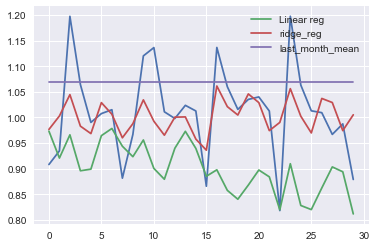

In [640]:
plt.plot(y_test.values)
plt.plot(preds['lin_reg'], label = 'Linear reg')
plt.plot(preds['ridge_reg_deg_2'], label = 'ridge_reg')
plt.plot(preds['last_month_mean'], label = 'last_month_mean')
plt.legend()
plt.show()

In [929]:
# check R2 and MAE - added differenced lag - Fortmat for moving data between Dash Callbacks
eval_metrics = []
for res in preds.keys():
    scores = {}
    scores['R^2'] = (r2_score(y_test, preds[res]))
    scores['MAE'] = (mean_absolute_error(y_test, preds[res]))
    
    eval_metrics.append(scores)

In [928]:
data.to_dict(orient='records')

[{'R^2': -1.6340432612083395, 'MAE': 0.12118219973603409},
 {'R^2': 0.27899148413551045, 'MAE': 0.059400889454304474},
 {'R^2': -0.40279425484894693, 'MAE': 0.08610580864415246}]

In [596]:
# Feature Importance 
feat_imp = pd.DataFrame(index = pipe_gf['poly'].get_feature_names(x_train.columns),
             data = pipe_gf['scale'].inverse_transform(pipe_gf['ridge'].coef_))
feat_imp.sort_values(by = 0, ascending=False)[:10]

0
Days_since_03-13^2          8194.864583
Days_since_03-13 day        1225.253104
Days_since_03-13 month       501.783546
day^2                        330.101439
Days_since_03-13 day_week    237.906116
Lag_7days Days_since_03-13    83.794859
Lag_6days Days_since_03-13    83.702155
Lag_5days Days_since_03-13    83.673773
Lag_4days Days_since_03-13    83.555608
Lag_1days Days_since_03-13    83.387895

In [283]:
# check R2 and MAE - with only single lagged var and date vars.

for res in preds.keys():
    print(f'R^2 {res} : {r2_score(y_test, preds[res])}')
    print(f'MAE {res} : {mean_absolute_error(y_test, preds[res])}')

R^2 lin_reg : -1.5627223279091011
MAE lin_reg : 0.11332239142089456
R^2 ridge_reg_deg_2 : 0.11486299655149057
MAE ridge_reg_deg_2 : 0.06008390201263141
R^2 last_month_mean : -0.38432315782056015
MAE last_month_mean : 0.08238130601472946


In [262]:
# check R2 and MAE - with only the single lagged var.

for res in preds.keys():
    print(f'R^2 {res} : {r2_score(y_test, preds[res])}')
    print(f'MAE {res} : {mean_absolute_error(y_test, preds[res])}')

R^2 lin_reg : -0.4954675009423126
MAE lin_reg : 0.08497170041409818
R^2 ridge_reg_deg_2 : -0.009287634151024182
MAE ridge_reg_deg_2 : 0.059359228161031605
R^2 last_month_mean : -0.38432315782056015
MAE last_month_mean : 0.08238130601472946


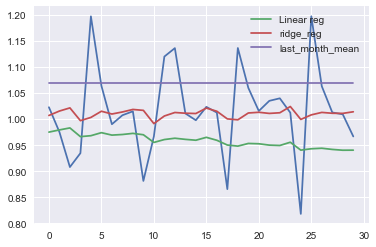

In [259]:
plt.plot(y_test.values)
plt.plot(preds['lin_reg'], label = 'Linear reg')
plt.plot(preds['ridge_reg_deg_2'], label = 'ridge_reg')
plt.plot(preds['last_month_mean'], label = 'last_month_mean')
plt.legend()
plt.show()

In [441]:
# Growth factor of last two days can't be calculated, so - truncating x by 2 days
# optimising hyperparameters of ridge regression, 2nd order polynomial features used
hyp = []
for alp in np.linspace(1,3000, num=1000):
    pipe_gf = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('scale', StandardScaler()),('ridge', Ridge(alpha = alp))])
    #x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = .3, shuffle = False)
    pipe_gf.fit(x_train,y_train)
    pipe_gf.score(x_test, y_test)
    preds = pipe_gf.predict(x_test)
    hyp.append(mean_absolute_error(y_test, preds))

In [443]:
np.linspace(1, 3000, num=1000)[np.array(hyp).argmin()]

22.014014014014016

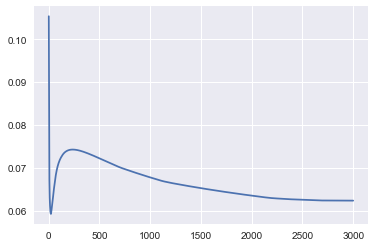

In [444]:
plt.plot(np.linspace(1, 3000, num=1000), hyp)

### Time- Series Approach Taking the Weekly moving average

In [11]:
from statsmodels.tsa import seasonal
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.estimator_checks import check_estimator

In [811]:
class TimeSeriesGrowthFactor():
    """Sklearn Regression wrapper for SARIMA(1, 1, 1)x(0, 1, 1, 7) model used for predicting Growth Factor.
    Runs ADF test for the transformation and if significant only then does it allow a model to be fit.
    Else Error out.
    """

    def __init__(self): # SARIMAX try with inheriting SARIMAX
        # Private Attribute To check if time-series is stationary and fitted.
        self.__valid = None

    def fit(self, ts):
        self.Y = ts

        # taking moving average to remove seasonality.
        self.__Y = self.Y.rolling(window=7).mean()[6:]
        # removing trend
        self.__Y =  self.__Y.diff(periods=1)[1:]
        # performing ADF test
        self.adf_results = stattools.adfuller(self.__Y, maxlag=None, autolag='AIC')

        # check if p-value is less than 0.05 to reject presence of unit root
        # then fit model.
        if self.adf_results[1] > 0.05:
            self.__valid = 0
            raise NotFittedError(
                'Can\'t Fit estimator. Time-Series likely not stationary with current SARIMA parameters')
        
        # setup and fit model if we don't error out.
        self.model = statespace.sarimax.SARIMAX(self.Y, trend='n', order=(1,1,1), seasonal_order=(0,1,1,7))
        
        # change status for stationary and fit.
        self.__valid = 1
        
        # result wrapper with all params and summary visible.
        self.res_model = self.model.fit()
        
    def predict(self, X_start, X_end):
        """Pass in number of days since(X_start) and to(X_end) for which forecast is required.
        """
        if self.__valid is None:
            raise NotFittedError("Estimator instance is not fitted yet. Call 'fit'")
            
        return self.res_model.predict(start = X_start, end=X_end)

In [824]:
model = TimeSeriesGrowthFactor()

In [908]:
model.fit(y_train)

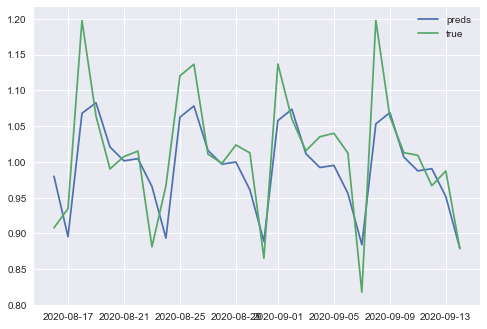

In [857]:
# validation set preds
plt.plot(model.predict(X_start=len(x_train), X_end=len(x_train) + len(x_test))[:-1], label = 'preds')
plt.plot(y_test, label = 'true')
plt.legend()
plt.show()

In [738]:
def perf_adf(ts):
    """Performs ADF test on time series and prints Results.
    """
    dftest = stattools.adfuller(ts, maxlag=None, autolag='AIC')
    df_result = pd.Series(dftest[:4], index = ['Test- Stat', 'P-Value', '# of Lags Used', '# of Obs Used'])
    # For Critical values at diff. confidence intervals
    for key, value in dftest[4].items():
        df_result[f'Critical Value {key}'] = value
    return df_result.head(10)

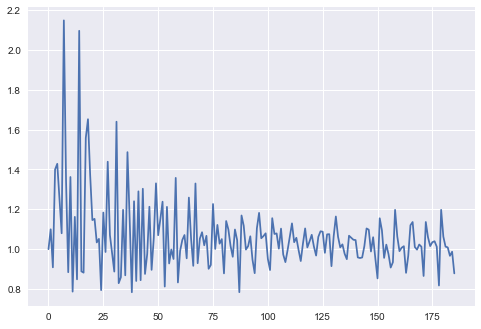

In [668]:
#original series
plt.plot(india_growth_factor[2:].to_list())

In [739]:
perf_adf(india_growth_factor[2:])

Test- Stat             -3.907637
P-Value                 0.001979
# of Lags Used         15.000000
# of Obs Used         170.000000
Critical Value 1%      -3.469413
Critical Value 5%      -2.878696
Critical Value 10%     -2.575917
dtype: float64

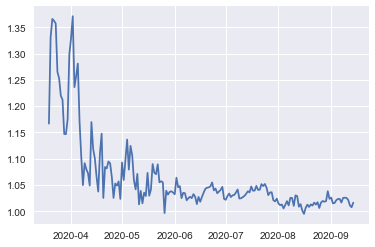

In [600]:
# this is just removing the seasonal component.
x_ma = india_growth_factor[2:].rolling(window=7).mean()[6:]
plt.plot(x_ma)

In [601]:
perf_adf(x_ma)

Test- Stat           -8.143180e+00
P-Value               1.015192e-12
# of Lags Used        1.400000e+01
# of Obs Used         1.650000e+02
Critical Value 1%    -3.470616e+00
Critical Value 5%    -2.879221e+00
Critical Value 10%   -2.576197e+00
dtype: float64

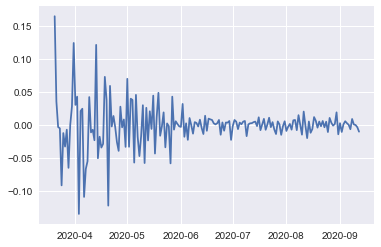

In [452]:
# removing trend
plt.plot(x_ma.diff(periods=1))

In [453]:
perf_adf(x_ma.diff(periods=1)[1:])

Test- Stat             -4.063690
P-Value                 0.001111
# of Lags Used         13.000000
# of Obs Used         163.000000
Critical Value 1%      -3.471119
Critical Value 5%      -2.879441
Critical Value 10%     -2.576314
dtype: float64

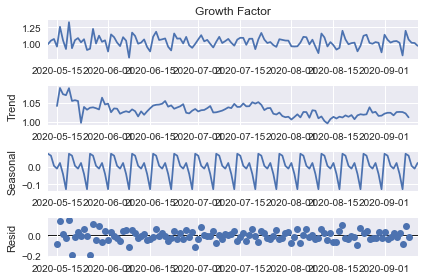

In [454]:
# Same as Decomposing into components
res = seasonal.seasonal_decompose(india_growth_factor[62:], model='additive')
plt_season = res.plot()
# Has a decent seasonal component. Very inconcistent trend.

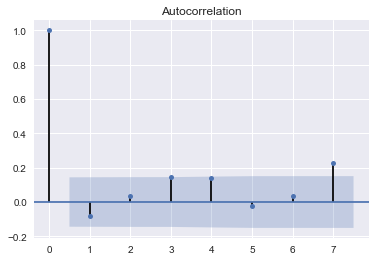

In [602]:
# plot acf for order of process
acf = plot_acf(india_growth_factor[2:], lags=7, alpha = 0.05)

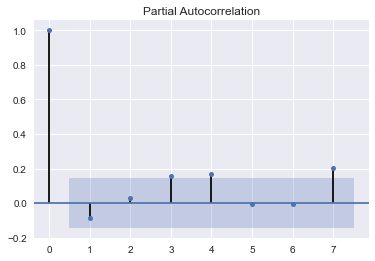

In [603]:
# AR 1 can be suitable, function 
pacf = plot_pacf(india_growth_factor[2:], lags = 7, alpha = 0.05)

In [609]:
# arima with order 1,1 and differecing of 1 so, (p,d,q) = (1,1,1)
model = arima_model.ARIMA(y_train, order = (1,1,2))
res_model = model.fit(trend='nc', method='css-mle')
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



-72.47032625618948

In [611]:
res_model.params

ar.L1.D.Growth_Factor    0.651832
ma.L1.D.Growth_Factor   -1.879653
ma.L2.D.Growth_Factor    0.917923
dtype: float64

In [612]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.Growth_Factor   No. Observations:                  148
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  40.235
Method:                       css-mle   S.D. of innovations              0.182
Date:                Tue, 15 Sep 2020   AIC                            -72.470
Time:                        03:17:35   BIC                            -60.481
Sample:                    03-21-2020   HQIC                           -67.599
                         - 08-15-2020                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ar.L1.D.Growth_Factor     0.6518      0.179      3.641      0.000       0.301       1.003
ma.L1.D.Growth_Factor    -1.8797      0.115    -16.380      0.000      -2.105      -1.655
ma.L2.D.Growth_Factor     0.9179      0.105      8.740      0.000       0.712       1.124
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5341           +0.0000j            1.5341            0.0000
MA.1            1.0239           -0.2028j            1.0438           -0.0311
MA.2            1.0239           +0.2028j            1.0438            0.0311
-----------------------------------------------------------------------------
"""

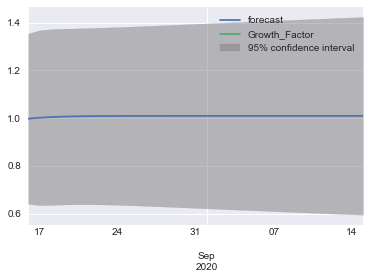

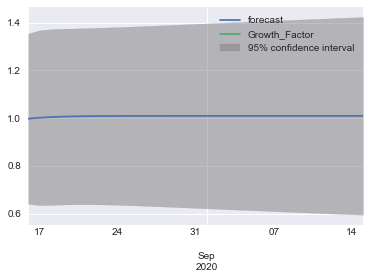

In [613]:
pd.options.plotting.backend = 'matplotlib'
res_model.plot_predict(start = len(x_train), end=len(x_train) + len(x_test))

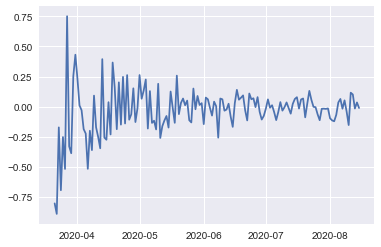

In [614]:
plt.plot(res_model.resid)

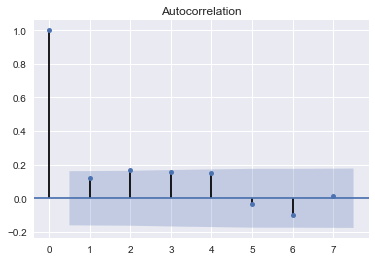

In [615]:
acf = plot_acf(res_model.resid, lags = 7, alpha = 0.05)

In [863]:
statespace.sarimax.SARIMAX

statsmodels.tsa.statespace.sarimax.SARIMAX

In [790]:
model = statespace.sarimax.SARIMAX(y_train, trend='n', order=(1,1,1), seasonal_order=(0,1,1,7))
res_model = model.fit()
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



-48.856507156307714

In [617]:
res_model.params

ar.L1     -0.284672
ma.L1     -0.956025
ma.S.L7   -0.700593
sigma2     0.036657
dtype: float64

In [618]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     Growth_Factor   No. Observations:                  149
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                  28.428
Date:                           Tue, 15 Sep 2020   AIC                            -48.857
Time:                                   03:17:49   BIC                            -37.061
Sample:                               03-20-2020   HQIC                           -44.063
                                    - 08-15-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2847      0.058     -4.941      0.000      -0.398      -0.172
ma.L1         -0.9560      0.078    -12.325      0.000      -1.108      -0.804
ma.S.L7       -0.7006      0.070    -10.076      0.000      -0.837      -0.564
sigma2         0.0367      0.003     10.796      0.000       0.030       0.043
===================================================================================
Ljung-Box (Q):                       38.03   Jarque-Bera (JB):               247.57
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

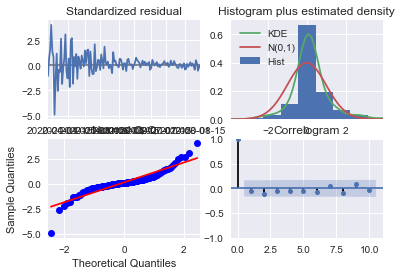

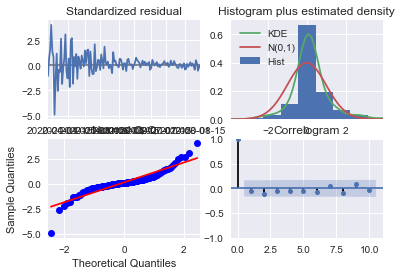

In [619]:
res_model.plot_diagnostics()

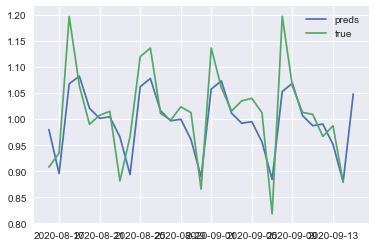

In [620]:
# validation set preds
plt.plot(res_model.predict(start = len(x_train), end=len(x_train) + len(x_test)), label = 'preds')[-len(x_test):]
plt.plot(y_test, label = 'true')
plt.legend()
plt.show()

In [632]:
# R^2, MAE
preds = res_model.predict(start = len(x_train), end=len(x_train) + len(x_test))
r2_score(y_test, preds[:-1])

0.6240804481243416

In [631]:
mean_absolute_error(y_test, preds[:-1])

0.04100734902628821

### Growth Ratio of Virus
The growth ratio on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.
Percentage Increase in total cumulative Cases from one day to the next. <br>
Looking at the graph, there is an unmistakable downward trend to the growth ratio, with a 6% growth in the number of cases occuring on the 24th April compared  to highs of 25-30% since the start of reliable testing. A linear relationship does not appear to be a suitable realtionship according to the residual plot and an exponential decay could be more suitable.

 Mean growth Ratio of Cases In India : 1.0590361840636529


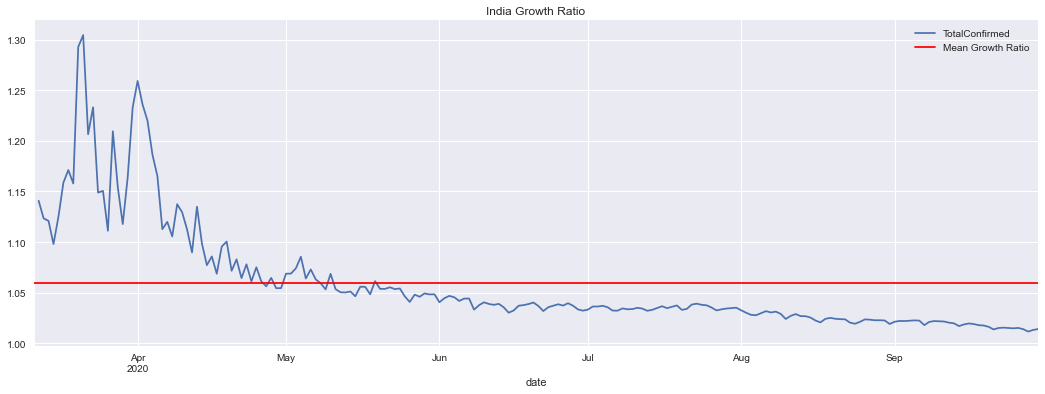

In [576]:
pd.options.plotting.backend = 'matplotlib'
growth_ratio_india = india_data.TotalConfirmed[41:]/india_data.TotalConfirmed[41:].shift(1)
print(f' Mean growth Ratio of Cases In India : {growth_ratio_india.mean()}')
growth_ratio_india.plot(grid = True, title = 'India Growth Ratio', figsize = (18,6))
plt.axhline(growth_ratio_india.mean(), color = 'r', label='Mean Growth Ratio')
plt.legend()
#plt.savefig(path_graphs + 'India_Growth_Ratio')
plt.show()

In [577]:
def growth_ratio(TotalConfirmed):
    growth_ratio_india = TotalConfirmed/TotalConfirmed.shift(1)
    growth_ratio_india = growth_ratio_india.to_frame(name = 'Growth_Ratio')
    growth_ratio_india.dropna()
    return growth_ratio_india

In [578]:
growth_ratio_india = growth_ratio(india_data.TotalConfirmed[41:])

In [579]:
pd.options.plotting.backend = 'plotly'
mean_growth_ratio = growth_ratio_india['Growth_Ratio'].mean()

fig = growth_ratio_india.plot(title = "India Growth Ratio", labels = dict(index = " ", value = "Growth Ratio"))
fig.update_layout(legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ), legend_title_text='',
            margin=dict(
                t= 10,
                b=20,
                pad=1
            ))
fig.update_xaxes(title_text="Date")

fig.add_scatter(y = [mean_growth_ratio, mean_growth_ratio],
               x =[growth_ratio_india.index.min(), growth_ratio_india.index.max()], mode='lines',
               name = f'Mean Growth Ratio : {round(mean_growth_ratio,3)}')
fig.show()

#### Try Poisson Regression
https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html

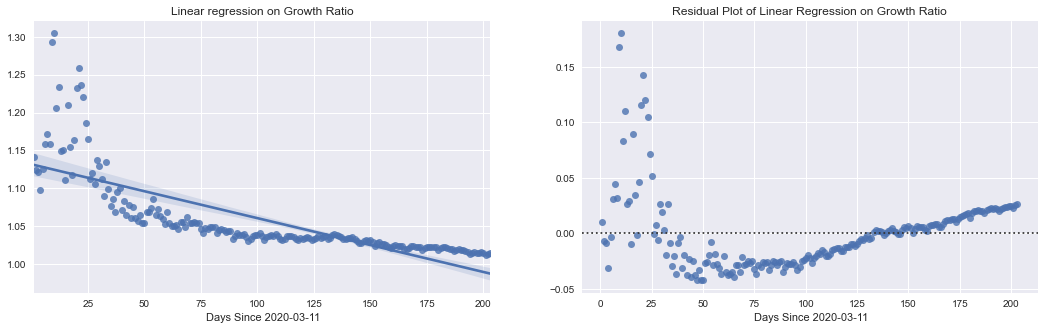

In [580]:
growth_ratio_list = growth_ratio_india['Growth_Ratio'].tolist()

fig, ax = plt.subplots(1,2, figsize = (18,5))
sns.regplot(x = np.arange(len(growth_ratio_list)) , y =growth_ratio_list, ax = ax[0])
ax[0].set_title('Linear regression on Growth Ratio')
ax[0].set_xlabel(' Days Since 2020-03-11')
sns.residplot(x = np.arange(len(growth_ratio_list)) , y =growth_ratio_list, ax =  ax[1] )
ax[1].set_title('Residual Plot of Linear Regression on Growth Ratio')
ax[1].set_xlabel(' Days Since 2020-03-11')
#plt.savefig(path_graphs +'India_Growth_Factor_Pred')
plt.show()

#### Generalised Linear Models - Poisson and Gamma Regression
one problem, these don't go below 0. So, only suitable for short term preds. <br>
OR <br>
subtract 1 to transform target to correct bounds. <br>
Evaluating performance of GLMs usign R^2 is a no-go. Also not all assumptions of Poisson and Gamma regression are met, but these models can still be useful for short-term forecast. 
Resources :
1. https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function
2. https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression

To Do:
1. Create class of estimators, maybe transformation for pipeline.
2. Using just the lagged features of the past 7,14 days and linear regression outperforms all the modelling I've been doing till now :/
3. I've indirectly created an Autoregressive model ! The transformation class can create lagged features AR(7) which has the first seasonal term (7th lag) when used without date and differenced features. LMAO (Done)
4. *Create a pipeline for the three regression models to easily evaluate different feature combinations etc. And table with perf here. Finish the Growth ratio module today. (Done)

In [6]:
from sklearn.linear_model import PoissonRegressor, LinearRegression, GammaRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [7]:
# Lets try creating a custom transformer
# idea is to just feed it total confirmed column and it creates the lagged, date and diffed features(Hyperparamters).
# Returning ready to be integrated into pipeline data - x_train, y_train.

# baseestimator gives you get_params, set_params and TransformerMixin gives you fit_transform.

from sklearn.base import BaseEstimator, TransformerMixin


class GrowthRatioFeatures(BaseEstimator, TransformerMixin):
    """Data transformation for easily creating Growth ratio features from the total confirmed cases.
    Total confirmed is a date indexed series with total confirmed covid cases. If GLM bounds is true,
    shifts growth ratio into the correct range [0,+inf] by subtracting 1.
    First calculates the growth ratio. Performs the following transformations.
    Lagged Feats - Lag of growth ratio for t days.
    Diffed Feats - 1st Differed growth ratio of t lags. Useful to encode trend information.
    Date Feats - used to create date feats like month, day, dayofweek to help encode seasonality.
    """

    def __init__(self, num_lagged_feats=7, num_diff_feats=1, date_feats=True, glm_bounds=True):
        self.num_lagged_feats_ = num_lagged_feats
        self.num_diff_feats_ = num_diff_feats
        self.date_feats_ = date_feats
        self.glm_bounds_ = glm_bounds

    def fit(self, X, y=None):
        # nothing to calculate for a transformation ex, calculating mean of data etc.
        # could add gr calculation here.
        return self

    def transform(self, X, y=None):
        # calculating growth ratio (target, y)
        self.y = X/X.shift(1)
        self.y = self.y.to_frame(name='Growth_Ratio')
        self.y.dropna(inplace=True)
        # subtracting 1 to get into right bounds.
        if self.glm_bounds_ == True:
            self.y = self.y - 1

        # creating features (featres, x) - important to create a copy of target here, otherwise overwrites y

        self.X = self.y.copy()

        # creating lagged features
        for i in range(1, self.num_lagged_feats_+1):
            self.X[f'Lag_{i}days'] = self.y.shift(i)
            
        # creating date features 
        if self.date_feats_ == True:
            self.X['month'] = self.X.index.month
            self.X['day'] = self.X.index.day
            self.X['day_week'] = self.X.index.dayofweek
            self.X[f'Days_since_{self.X.index.date.min()}'] = np.arange(len(self.X.index.tolist()))
        
        # creating differenced features 
        # check to see if lagged features exist and num of diff features less than lagged feats.
            if (self.num_lagged_feats_ >=1) & (self.num_lagged_feats_ >= self.num_diff_feats_):
                
                for i in range(1, self.num_diff_feats_+1):
                    self.X[f'Lag_{i}days_diff'] = self.X[f'Lag_{i}days'].diff(1)
            else:
                print('Number of diffed lag features requested higher than number of lagged features')
        
        # dropping growth ratio(target) from x
        self.X.drop('Growth_Ratio', axis = 1, inplace = True)
        
        # if no features generated, pass just the days since feature as feature(can break)
        if self.X.shape[1] == 0:
            self.X[f'Days_since_{self.X.index.date.min()}'] = np.arange(len(self.X.index.tolist()))
        
        return self.X, self.y

In [8]:
def train_test_split_gr(x, y, validation_days = 30):    
    """Return in form of numpy array ?"""
   # Removing all NaN values - not best to abstract this away
    index = x.isna().sum().max()
    print(f'{index} samples (Days) dropped from start of feature vector due to nans')
    x_temp = x[index:]
    target = y[index:]
    # train-test split

    z = validation_days
    x_train = x_temp[:-z]
    x_test = x_temp[-z:]
    y_train = target[:-z]
    y_test = target[-z:]

    return x_train.values, x_test.values, y_train.values.ravel(), y_test.values.ravel()

In [11]:
trf = GrowthRatioFeatures(num_lagged_feats=7, num_diff_feats=1, date_feats=True, glm_bounds=True)

# FOR REGRESSION MODELS
x, y = trf.transform(india_data.TotalConfirmed[41:])
x_train, x_test, y_train, y_test =  train_test_split_gr(x, y, validation_days=30)
# perform ADF test
if perf_adf(y)[1] < 0.05 :
    print('Stationary Series')
    
# FOR AR(7) MODEL
trf_ar = GrowthRatioFeatures(num_lagged_feats=7, num_diff_feats=0, date_feats=False, glm_bounds=True)

x_ar, y_ar = trf_ar.transform(india_data.TotalConfirmed[41:])
x_train_ar, x_test_ar, y_train_ar, y_test_ar =  train_test_split_gr(x_ar, y_ar, validation_days=30)
# perform ADF test
if perf_adf(y_ar)[1] < 0.05 :
    print('Stationary Series')
    
# Scaling for Poisson and Gamma Regression models, they use L2 regularization penalty
# pass list of named tuples - (name, contructor)

# adding polynomial features :O
pipe_lin_reg_ar = Pipeline([('poly', PolynomialFeatures(1, include_bias=False)),
                            ('scale', StandardScaler()), ('reg_lin', LinearRegression())])

pipe_lin_reg = Pipeline([('poly', PolynomialFeatures(1, include_bias=False)),('scale', StandardScaler()), ('reg_lin', LinearRegression())])
pipe_reg_pois = Pipeline([('poly', PolynomialFeatures(1, include_bias=False)),('scale', StandardScaler()), ('reg_pois', PoissonRegressor(alpha=0, max_iter=5000))])
pipe_reg_gamm = Pipeline([('poly', PolynomialFeatures(2)),('scale', StandardScaler()), ('reg_gamm', GammaRegressor(alpha=0, max_iter=5000))])

pipe_lin_reg_ar.fit(x_train_ar, y_train_ar)
pipe_lin_reg.fit(x_train, y_train)
pipe_reg_pois.fit(x_train, y_train)
pipe_reg_gamm.fit(x_train, y_train)

print('Lin_Reg_AR: ',pipe_lin_reg_ar.score(x_test_ar, y_test_ar), mean_absolute_error(y_test_ar, pipe_lin_reg_ar.predict(x_test_ar)))
print('Lin_Reg: ',pipe_lin_reg.score(x_test, y_test), mean_absolute_error(y_test, pipe_lin_reg.predict(x_test)))
print('Poi_Reg: ',pipe_reg_pois.score(x_test, y_test), mean_absolute_error(y_test, pipe_reg_pois.predict(x_test)))
print('Gamma_Reg: ',pipe_reg_gamm.score(x_test, y_test), mean_absolute_error(y_test, pipe_reg_gamm.predict(x_test)))

7 samples (Days) dropped from start of feature vector due to nans
Stationary Series
7 samples (Days) dropped from start of feature vector due to nans
Stationary Series
Lin_Reg_AR:  0.6779339490111536 0.0015253052437060614
Lin_Reg:  -4.244057198987059 0.007584027885826557
Poi_Reg:  0.6186003655786347 0.0017466500404605078
Gamma_Reg:  0.7519073694684649 0.0013310880042472569


| MODEL  | FEATS  | $R^2$  | MAE  |
|---|---|---|---|
| LinReg  |  Just days since start |  -140.9141 | 0.03907  | 
|  Poisson |   | -2.987  |  0.00572 | 
|  Gamma |   |  -0.0144 |   0.00286| 
| LinReg  |  Single Lagged feat (AR1)|  -0.1336 | 0.00317  | 
|  Poisson |   | -19.4151  |  0.01911 | 
|  Gamma |   |  -7.0814 |   0.01337| 
| LinReg  |  7 Lagged feat (AR7)|  0.6749 |  0.00148  | 
|  Poisson |   | -11.8144  |  0.01422 | 
|  Gamma |   |  -5.8317 |   0.01172| 
| LinReg  |  Single Lagged Date feat|  -9.8081 | 0.01068  |
|  Poisson |   | 0.5934  |  0.00185 | 
|  Gamma |  |  0.4494 |   0.00188|
| LinReg  |  7 Lagged Date feat|  -5.6463 | 0.00839  |
|  Poisson |   | 0.6309  |  0.00165 | 
|  Gamma |  |  0.6117 |   0.00176|
|  LinReg | Adding differenced features (negligible difference on all models) |  -5.6463 |   0.00839|
| LinReg  |  7 Lagged Date feat 2nd order polynomial features|  -3.4534 | 0.00623  |
|  Poisson |   | 0.4672  |  0.00195 | 
|  Gamma |  |  0.7536 |   0.00132|

In [12]:
lin_preds = pipe_lin_reg_ar.predict(x_ar.dropna())
pos_preds = pipe_reg_pois.predict(x.dropna())
gam_preds = pipe_reg_gamm.predict(x.dropna())

In [27]:
preds = pd.DataFrame(data =  np.concatenate((np.concatenate((y_train, y_test)).reshape(-1,1), lin_preds.reshape(-1,1),pos_preds.reshape(-1,1), gam_preds.reshape(-1,1)),
                                    axis = 1), columns=['TrueGR','ARModel', 'PoissonReg', 'GammaReg'])
preds.index = x.dropna().index

In [59]:
pd.options.plotting.backend = 'plotly'


fig = go.Figure()

fig = preds.drop(['TrueGR'], axis = 1).plot(kind='scatter')

fig.add_trace(go.Scatter(x=preds.index, y=preds['TrueGR'], name = 'TrueGR',
                         line=dict(color='royalblue', width=4)))

fig.update_layout(shapes=[
        dict(
            type='line',
            yref='paper', y0=0, y1=1,
            xref='x', x0=preds.index[-30], x1=preds.index[-30]
        )
    ], legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ), legend_title_text='',
        margin=dict(
            b=15,
            t=5,
            l=50,
            r=50,
            pad=1
        ),
    )
#fig.update_traces(line=dict(dash="dashdot", width=10),mode='lines+markers')
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=2,
                        subplot_titles=("Logistic function fit to Cumulative Cases",
                                        "Validation Set Predictions for Daily Cases"),
                        column_widths=[0.6, 0.4],
                        horizontal_spacing=0.08)

    fig_1 = df.rename(columns={'TotalConfirmed': 'ActualCases'})['ActualCases'].plot(kind='scatter')

    fig_1.update_traces(
        line=dict(dash="dot", width=10)
    )

    fig.append_trace(fig_1['data'][0], 1, 1)

    fig.update_traces(marker=dict(color="#636EFA"),
                      row=1, col=1)

    fig.add_scatter(x=df.index, y=preds.ravel(),
                    name='Fit Line',
                    line=dict(
                        color="#EF553B",
                        width=2),
                    marker=dict(
                        opacity=0.4)
                    )

    # second figure - index is 29 days as 1 day differenced away

    fig_2 = px.line(x=india_data.index[-29:], y=np.diff(y_test, n=1), title="ActualCases")
    fig_2.add_scatter(x=india_data.index[-29:], y=np.diff(preds_test.ravel(), n=1), mode='lines',
                      name='Predicted Cases',
                      line=dict(
                          color="#EF553B"),
                      )
    fig_2['data'][1].showlegend = False
    fig.append_trace(fig_2['data'][0], 1, 2)
    fig.append_trace(fig_2['data'][1], 1, 2)

    fig.update_layout(shapes=[
        dict(
            type='line',
            yref='paper', y0=0, y1=1,
            xref='x', x0=df.index[-30], x1=df.index[-30]
        )
    ], legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1
    ), legend_title_text='',
        margin=dict(
            b=15,
            t=5,
            l=50,
            r=50,
            pad=1
        ),
    )
    # Axis Titles
    fig.update_yaxes(title_text="Cases", row=1, col=1)
    fig.update_yaxes(title_text="Cases", row=1, col=2)

##### Linear Regression

In [1186]:
# R^2
pipe_lin_reg.score(x_test, y_test)

-5.646391981819002

In [1187]:
mean_absolute_error(y_test, pipe_lin_reg.predict(x_test))

0.00839569986113347

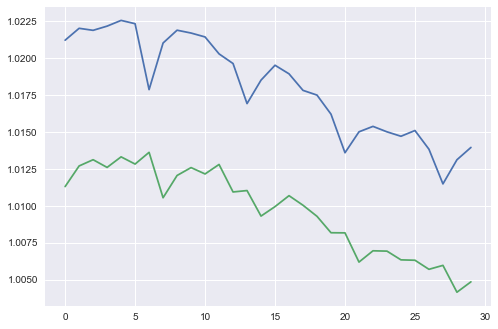

In [1188]:
plt.plot(y_test +1 )
plt.plot(pipe_lin_reg.predict(x_test) + 1)

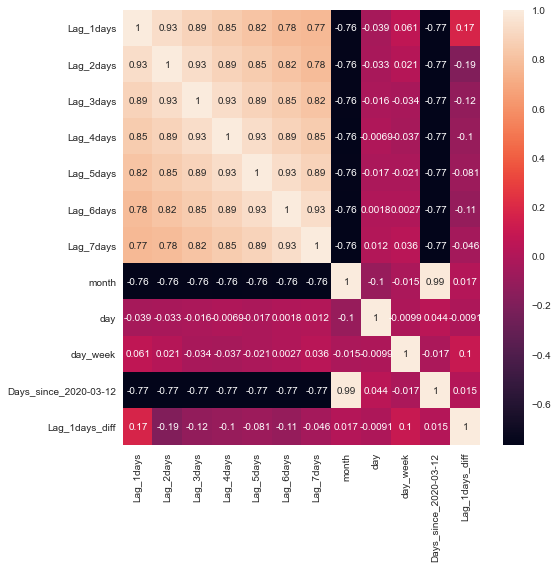

In [1189]:
import seaborn as sns

plt.figure(figsize=(8,8))
sns.heatmap(x.corr(), annot=True)
plt.show()

In [1122]:
pd.DataFrame(index = x.columns, data = pipe_lin_reg['reg_lin'].coef_).sort_values(by = 0, axis = 0)

0
Days_since_2020-03-12 -0.353307
Lag_5days             -0.011599
day_week              -0.000575
Lag_6days              0.000548
Lag_3days              0.000663
Lag_4days              0.002880
Lag_1days_diff         0.005876
Lag_7days              0.010465
Lag_2days              0.022190
Lag_1days              0.024617
day                    0.065384
month                  0.352010

In [1249]:
# y = mx + c
print(pipe_lin_reg['reg_lin'].coef_,pipe_lin_reg['reg_lin'].intercept_)
lin_preds = pipe_lin_reg.predict(x.dropna())

[ 0.04069065  0.00718332  0.00125527  0.00316299 -0.01179267  0.00105285
  0.01124731] 0.06327745054241324


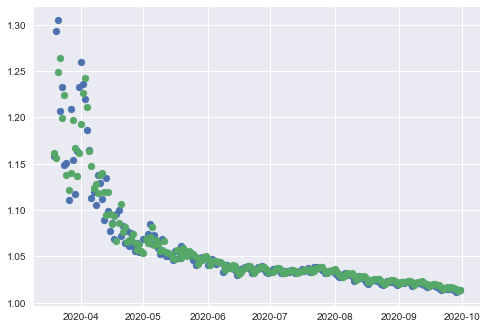

In [1252]:
plt.scatter(x = x_ar.dropna().index , y =np.concatenate((y_train, y_test)) + 1)
plt.scatter(x= x_ar.dropna().index ,y= lin_preds + 1)

In [1125]:
# residuals e = y-y^
residuals = np.concatenate((y_train, y_test)) + 1 - lin_preds

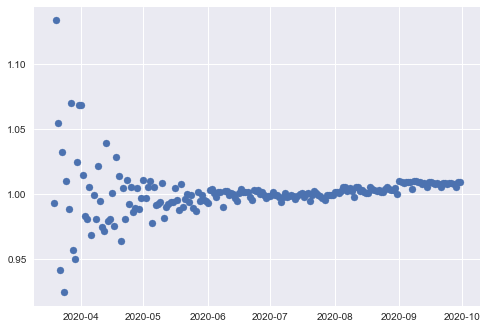

In [1126]:
plt.scatter(x = x_temp.index,y =  residuals)

##### Poisson Regression
The GLMs don't perform particularly better with lagged features etc. Isn't true, default regularization was the problem.

In [1191]:
pipe_reg_pois.score(x_test, y_test)

0.636784935251693

In [1192]:
mean_absolute_error(y_test, pipe_reg_pois.predict(x_test))

0.0016403534970730429

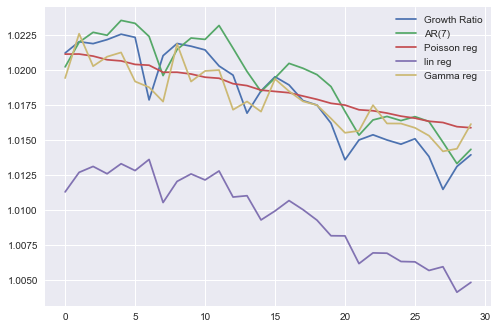

In [1112]:
plt.plot(y_test + 1, label ="Growth Ratio")
plt.plot(( pipe_lin_reg_ar.predict(x_test_ar) + 1), label = "AR(7)")
plt.plot( pipe_reg_pois.predict(x_test) + 1, label ="Poisson reg" )
#plt.plot(y_test.index, pois_reg_scale.predict(x_test_scale) + 1, label ="Poisson reg Scaled Time features" )
plt.plot(( pipe_lin_reg.predict(x_test) + 1), label = "lin reg")
#plt.plot(y_test.index, np.exp(reg_pois_single.predict(x_test_single)), label = "Poisson reg single feat ")
#plt.plot(y_test.index, np.exp(reg_gamm_single.predict(x_test_single)), label = "Gamma reg single feat")
plt.plot(pipe_reg_gamm.predict(x_test) + 1, label ="Gamma reg " )
plt.legend()
plt.show()

In [1194]:
print(pipe_reg_pois['reg_pois'].coef_,pipe_reg_pois['reg_pois'].intercept_)
#pos_preds = reg_pois_single.predict(x_temp['Days_since_03-13'].to_numpy().reshape(-1,1))
pos_preds = pipe_reg_pois.predict(x.dropna())

[ 0.13990235  0.12610988  0.00796819  0.02543191 -0.07365197  0.00688805
  0.08845258 -0.17510369 -0.04157582 -0.00422695 -0.18635367  0.03338374] -2.9908883971089772


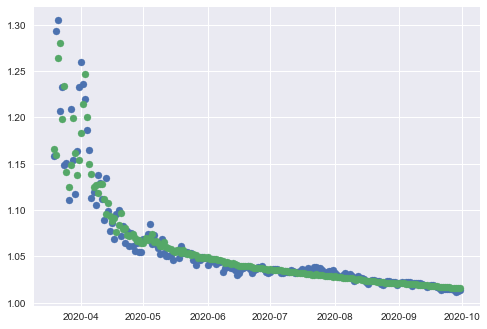

In [1195]:
plt.scatter(x = x_temp.index , y =target + 1)
plt.scatter(x= x_temp.index ,y= pos_preds + 1)

In [1084]:
residuals = (np.concatenate((y_train, y_test)) + 1) - pos_preds

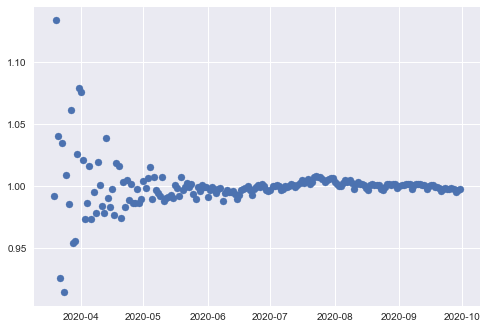

In [1085]:
plt.scatter(x = x_temp.index ,y =  residuals)

##### Gamma Regresion

In [1196]:
pipe_reg_gamm.score(x_test, y_test)

0.7536643174746269

In [1197]:
mean_absolute_error(y_test, pipe_reg_gamm.predict(x_test))

0.0013232640086314573

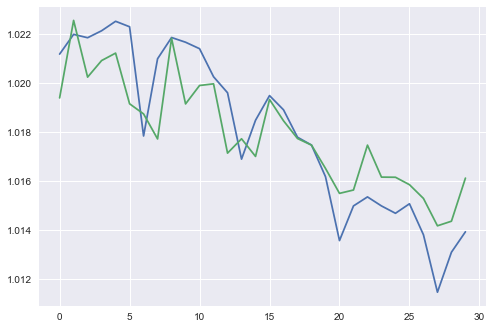

In [1198]:
plt.plot(y_test + 1)
plt.plot(pipe_reg_gamm.predict(x_test) + 1)

In [1199]:
print(pipe_reg_gamm['reg_gamm'].coef_,pipe_reg_gamm['reg_gamm'].intercept_)

[ 0.         -0.11325834 -0.03111382  0.01996875 -0.70502906 -0.53501547
 -0.68927564  0.08697038  0.85266627 -0.21992278 -0.10597737 -1.07799115
 -0.21166268 -0.69854967 -0.8981353   1.37126607  0.71786947 -0.7381258
  0.29308564 -0.30583477  0.64746358  0.27215587  0.28331178 -0.11668503
  0.44501835 -0.97805581  1.65267644  0.61918471 -0.92025305  0.29887035
 -0.33601789  0.7771568   0.30088213  0.28773213 -0.23254429  0.54990636
 -0.76286448 -1.62275937 -1.16259665 -1.4013469   1.32247012  0.85311484
 -0.17446277 -0.76504196 -0.07390746 -1.3086965   0.80635641  1.06467049
  0.24434408 -0.87849008 -0.17446184  0.32710509  0.07524133  0.06222416
  0.19684644  0.77265117 -0.38809178  0.75286953 -0.09271419  0.17697893
  0.53191995 -0.00984768  0.67988705  1.53296832 -0.56053986  0.25228431
 -0.32838973  0.00831808  0.08757482 -0.07576474 -0.95095049  0.83976574
  0.20713405 -0.23393576 -0.24359471  0.09296175  1.03957414  0.85451449
  0.26688774 -0.13702123 -0.30027148  0.14400491  0.

In [1200]:
gam_preds = pipe_reg_gamm.predict(x.dropna())

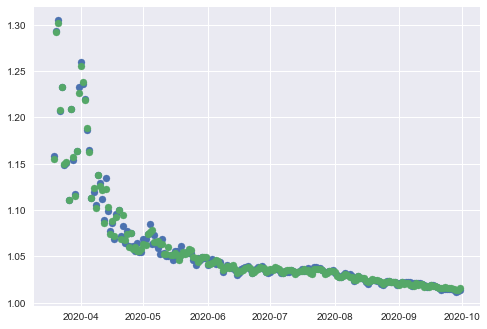

In [1091]:
plt.scatter(x = x_temp.index , y =np.concatenate((y_train, y_test)) + 1)
plt.scatter(x= x_temp.index ,y= gam_preds + 1)

In [1092]:
residuals = np.concatenate((y_train, y_test)) - gam_preds

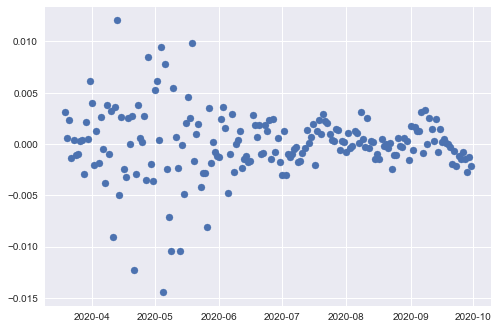

In [1093]:
plt.scatter(x = x_temp.index ,y =  residuals)

##### Predicting Number of cases for Validation Set using growth ratio

In [1201]:
preds = pd.DataFrame(index = x_temp.index,
                     data = np.hstack((lin_preds.reshape(-1,1),
                                       gam_preds.reshape(-1,1), pos_preds.reshape(-1,1),
                                       target.to_numpy().reshape(-1,1)
                                      )),
                columns = ['LinRegGR', 'GammaRegGR', 'PoissonRegGR', 'TrueGR'])

preds = preds + 1

In [1202]:
# copy for validation 
india_data_preds = india_data.join(preds, how = 'right')

india_DailyConfirmedValidation = india_data_preds.DailyConfirmed[-30:].copy()
india_DailyConfirmedValidation = india_DailyConfirmedValidation.to_frame('ActualCases')

In [1209]:

# iterating over DF and multiplying (i-1) days totalconf * predicted growth ratio for next day (i)= toatal conf day (i)

for i in range(-30,0):
    india_data_preds.TotalConfirmed.iloc[i+1] =  india_data_preds.TotalConfirmed.iloc[i] * india_data_preds.LinRegGR.iloc[i]
    india_data_preds.DailyConfirmed.iloc[i+1] = india_data_preds.TotalConfirmed.iloc[i+1]  - india_data_preds.TotalConfirmed.iloc[i]

india_DailyConfirmedValidation['LinRegGR'] = india_data_preds.DailyConfirmed.iloc[-30:]

#### Validation scores

In [1227]:
r2_score(india_DailyConfirmedValidation['ActualCases'][1:].astype(int), india_DailyConfirmedValidation['LinRegGR'][1:].astype(int))

-41.77028077083946

In [1232]:
mean_absolute_error(india_DailyConfirmedValidation['ActualCases'][1:].astype(int), india_DailyConfirmedValidation['LinRegGR'][1:].astype(int))

45081.06896551724

In [1234]:
r2_score(india_DailyConfirmedValidation['ActualCases'][1:].astype(int), india_DailyConfirmedValidation['GammaRegGR'][1:].astype(int))

-0.6104624308309483

In [1235]:
mean_absolute_error(india_DailyConfirmedValidation['ActualCases'][1:].astype(int), india_DailyConfirmedValidation['GammaRegGR'][1:].astype(int))

6761.241379310345

In [1236]:
r2_score(india_DailyConfirmedValidation['ActualCases'][1:].astype(int), india_DailyConfirmedValidation['PoissonRegGR'][1:].astype(int))

-1.62682694222939

In [1237]:
mean_absolute_error(india_DailyConfirmedValidation['ActualCases'][1:].astype(int), india_DailyConfirmedValidation['PoissonRegGR'][1:].astype(int))

9232.551724137931

1. Unscaled All Features 
2. Scaled All Features
3. No penalty Scaled All Features.

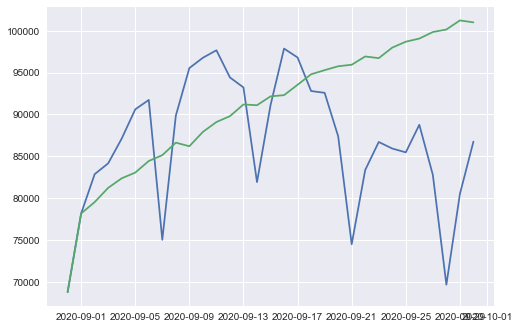

In [1106]:
#poisson
plt.plot(india_data.DailyConfirmed[-31:])
plt.plot(india_data_preds.DailyConfirmed[-31:])

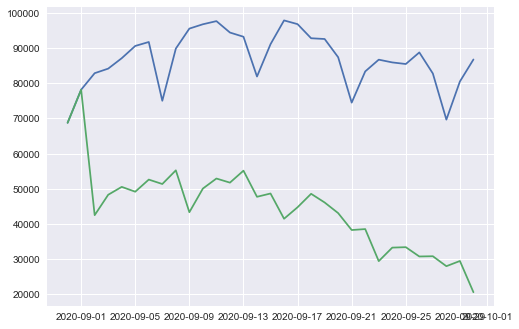

In [1168]:
#linear
plt.plot(india_data.DailyConfirmed[-31:])
plt.plot(india_data_preds.DailyConfirmed[-31:])

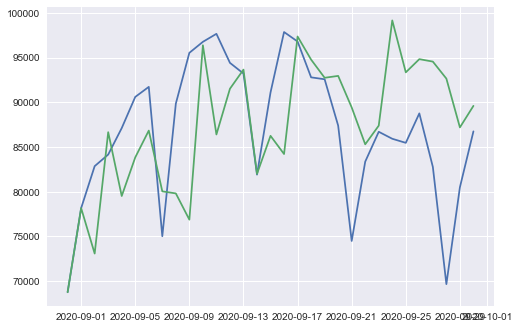

In [1109]:
# gamma
plt.plot(india_data.DailyConfirmed[-31:])
plt.plot(india_data_preds.DailyConfirmed[-31:])

###### Predicting for next how-ever many days. 
Creating features is a headache now.

In [893]:
### predict for next 30 days 
z = 30
x = np.arange(len(growth_ratio_india) + z)[1:]
preds = np.exp(reg_gamm.predict(x[-z:].reshape(-1, 1)))

In [894]:
# growth_ratio_india = india_data.TotalConfirmed[41:]/india_data.TotalConfirmed[41:].shift(1)

growth_ratio_india_pred = growth_ratio_india.append(pd.Series(preds, index=pd.date_range(growth_ratio_india.index[-1].date(), periods=31)[1:]))

In [896]:
india_data_preds = india_data.join(growth_ratio_india_pred.rename('Growth_Ratio'), how = 'right')

In [897]:
for i in range(-31, 0):
    india_data_preds.TotalConfirmed.iloc[i+1] =  india_data_preds.TotalConfirmed.iloc[i] * india_data_preds.Growth_Ratio.iloc[i]
    india_data_preds.DailyConfirmed.iloc[i+1] = india_data_preds.TotalConfirmed.iloc[i+1]  - india_data_preds.TotalConfirmed.iloc[i] 

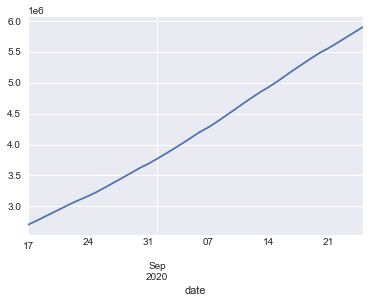

In [179]:
india_data_preds.TotalConfirmed[-40:].plot()

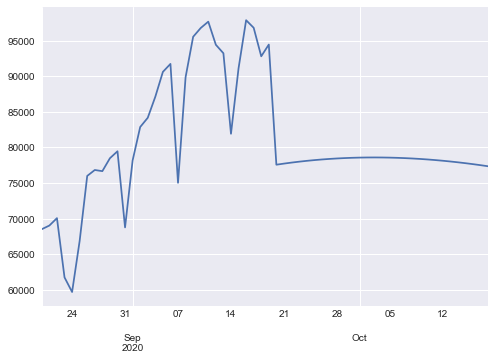

In [899]:
india_data_preds.DailyConfirmed[-60:].plot()

# 3. Modeling - Regularized Ridge Regression
<p>Due to a scarcity of features, the results should be taken with a grain of salt and are heavily influenced by the predictive power of the feature days since the outbreak .</p> First, the Growth factor and Growth Ratio are predicted for 'z' number of days using Ridge Regression. Ridge Regression applies half of the squared l2 norm of the weight vector as a regularization term or penalty to reduce overfitting and improve generalisation performance. This reduces in-sample training accuracy but will help the model generalise better in the absence of a large amount of features and training data.</p>
<p><b>Predictions: </b> The model has 86% validation set accuracy and a MSE of 13631. Using the Model to Predict the Total Confirmed Cases upto the next year, we see a maximum or plateau of 1,4 million confirmed Cases before the Total number of Active Cases starts to slow down around the January, Next Year.</p>

#### Growth Factor Predictions for the next 'z' Days

In [454]:
z = 31

#### Linear Regression to get Predicted Growth Factor
<p>The parameters for the ridge regression were found using the best validation set score using gridsearchCV</p>

In [27]:
# X is just days from 03-10
# Target is the growth factor on these days
# First two values from GF is nan, so from 03-12 to Current day used for training

In [459]:
# So, creating Features excluding first two days.
# x is days since 03-12
x = pd.DataFrame(index=pd.date_range(start='2020-03-13', periods=len(india_growth_factor.to_list())), 
            data = {'Days_since_03_12' : np.arange(1, len(india_growth_factor.to_list())+1)})
# Since growth factor calculation removes last two points 
x = x[:-2]
y = india_growth_factor.to_list()[2:]

In [460]:
# Growth factor of last two days can't be calculated, so - truncating x by 2 days
pipe_gf = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('scale', StandardScaler()),('ridge', Ridge(alpha = 5))])
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = .3, shuffle = False)
pipe_gf.fit(x_train,y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scale', StandardScaler()),
                ('ridge', Ridge(alpha=5))])

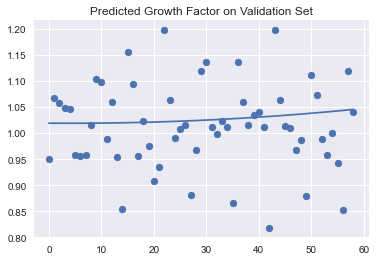

In [461]:
plt.scatter(x =np.arange(0, len(x_test)) ,y = y_test)
plt.plot(pipe_gf.predict(x_test))
plt.title('Predicted Growth Factor on Validation Set')
plt.show()

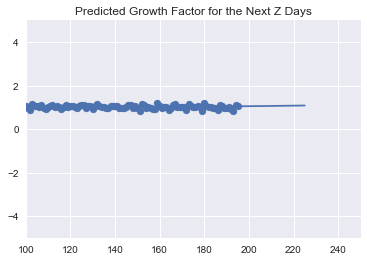

In [465]:
plt.scatter(x, y)
plt.ylim(-5,5)
plt.xlim(100,250)
plt.plot(pipe_gf.predict(np.arange(1, len(x)+1+z ).reshape(-1,1)))
plt.title('Predicted Growth Factor for the Next Z Days')
plt.show()

In [466]:
# Saving Predicted Grwoth Factor
pipe_gf.fit(x,y)
y_gf_pred = pipe_gf.predict(np.arange(len(x)-1, len(x)+z).reshape(-1,1))

#### Linear Regression to get Predicted Growth Ratio
<p>The parameters for the ridge regression were found using the best validation set score using gridsearchCV</p>

In [469]:
x = pd.DataFrame(index=pd.date_range(start='2020-03-13', periods=len(india_growth_factor)), 
            data = {'Days_since_03_12' : np.arange(1, len(india_growth_factor)+1)})
# Since growth Ratio calculation removes last two points 
x = x[:-2]
y_gr = growth_ratio_india['Growth_Ratio'].to_list()[2:]

In [470]:
pipe_gr = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('scale', StandardScaler()),('ridge', Ridge(alpha = 5))])
pipe_gr.fit(x, y_gr)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scale', StandardScaler()),
                ('ridge', Ridge(alpha=5))])

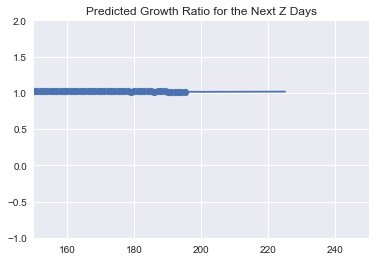

In [472]:
plt.scatter(x, y_gr)
plt.ylim(-1,2)
plt.xlim(150,250)
plt.plot(pipe_gr.predict(np.arange(1,len(x)+1+z).reshape(-1,1)))
plt.title('Predicted Growth Ratio for the Next Z Days')
plt.show()

In [473]:
# Saving These Predictions
y_gr_pred = pipe_gr.predict(np.arange(len(x)-1, len(x)+z).reshape(-1,1))

#### Storing Predicted Growth Factor and Ratio in Dataframe

In [474]:
x_pre = pd.DataFrame(index=pd.date_range(start=datetime.datetime.strftime(x[-1:].index[0] + datetime.timedelta(days=1),
                                                                          '%Y-%m-%d'), periods=32),
                     data={'Days_since_03_12': np.arange(len(x)+1, len(x)+z+2),
                           'GrowthFactor': y_gf_pred, 'GrowthRatio': y_gr_pred})

### Feature Engineering

####  Using Growth Factor as a feature

In [475]:
# Imputing Missing values with mean of growth factor from 11-03 to present day.
# df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)
india_data = data_to_df('covid')
india_data.date = pd.to_datetime(india_data.date)
india_data.set_index('date', inplace=True)
india_growth_factor_1 = growth_factor(india_data.TotalConfirmed[:])
india_growth_factor_1.replace(np.nan, india_growth_factor.min(), inplace=True)
india_growth_factor_1.replace(np.inf, india_growth_factor.min(), inplace = True)
india_growth_factor_1 = india_growth_factor_1.to_frame()
india_growth_factor_1.rename({'TotalConfirmed': 'GrowthFactor'}, axis=1, inplace=True)
# Merging the two dataframes
india_data = pd.concat([india_data, india_growth_factor_1], axis = 1)

####  Using Growth Ratio as a feature

In [476]:
growth_ratio_india_1 = india_data.TotalConfirmed[:]/india_data.TotalConfirmed[:].shift(1)
growth_ratio_india_1.replace(np.nan, 1, inplace = True)
growth_ratio_india_1 = growth_ratio_india_1.to_frame()
growth_ratio_india_1.rename(columns = {'TotalConfirmed' : 'GrowthRatio'} , inplace=True)
#growth_ratio_india_1 = growth_ratio_india_1.to_frame()
growth_ratio_india_1.rename(columns = {'TotalConfirmed' : 'GrowthRatio'} , inplace=True)
# Merging the two dataframes
india_data = pd.concat([india_data, growth_ratio_india_1], axis = 1)

#### Train Data
Reserving last 62 days for validation set.

In [477]:
# Days since widespread data Availibity. 03-12

india_data['Days'] = 0
# -2 due to the fact that last two growth facotrs and ratios are predicted, would be leakage, dropping last two points
x = india_data[['Days','GrowthFactor', 'GrowthRatio']][43:]
x['Days'] = np.arange(1, len(india_data[43:])+1)
x['Day_week'] = x.index.dayofweek.values
y = india_data['DailyConfirmed'][43:]
# Not Shuffling time-Series Data.
x_train, x_test, y_train, y_test = x[:-62], x[-62:], y[:-62], y[-62:]

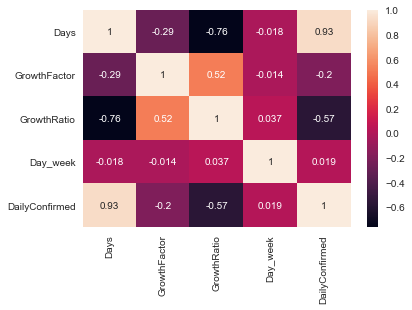

In [478]:
sns.heatmap(pd.concat([x, y], axis = 1).corr(method = 'pearson'), annot=True)

##  Lasso Regression
Has inbuilt regularisation in the form of L1 norm and also weighs down unimportant features.
<p> Hyperparameters found using Optimisation function below. The model seems to overfit using the days since substantial cases and is not a good indicator of long term predictions, it'll never go down and is likely to overestimate the Cases. Can be useful for short-term forecasting (1 month) here, compared to SARIMA later.</p>

### 1. Manual Hyperparameter Optimisation

In [491]:
def opt_alpha(list_alpha):
    # np.random.seed(10)
    res_r2 = []
    res_mse = []
    res_param = []
    for param in list_alpha:
        Input = [('poly', PolynomialFeatures(degree=2)), ('scale', StandardScaler()),
                 ('rid_reg', Lasso(alpha=param, max_iter=5000, tol=.001))]

        pipe = Pipeline(Input)
        pipe.fit(x_train, y_train)
        res_param.append(param)
        res_r2.append(pipe.score(x_test, y_test))
        res_mse.append(sqrt(mean_squared_error(y_test, pipe.predict(x_test))))
    return res_param, res_r2, res_mse

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 67044261.55593461, tolerance: 16844550.837879702

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 64997438.56321904, tolerance: 16844550.837879702

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 245928168.15759078, tolerance: 16844550.837879702

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:5

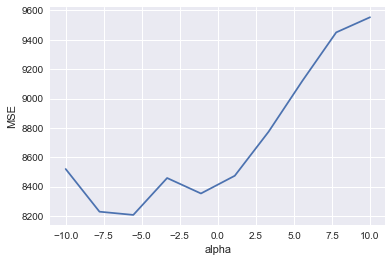

In [495]:
# Doesn't converge with current hyperparamters
param, r2, mse = opt_alpha(np.linspace(-10,10, 10))
plt.plot(param , mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

In [496]:
Input = [('poly', PolynomialFeatures(degree= 2)), ('scale', StandardScaler()),
         ('rid_reg', Lasso(alpha = -6, max_iter=5000))]

pipe= Pipeline(Input)
pipe.fit(x_train, y_train)
print('Test R2',pipe.score(x_test, y_test))
print('Test RMSE',sqrt(mean_squared_error(y_test, pipe.predict(x_test))))

Test R2 0.7207886614496841
Test RMSE 8213.635678662666


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 54314988.9156152, tolerance: 1684455.0837879702



### 2. Bayesian Hyperparameter Optimisation - Skopt

In [497]:
# Fix for some issue with Sklearn 0.23.0 and skopt 0.74
from numpy.ma import MaskedArray
import sklearn.utils.fixes

sklearn.utils.fixes.MaskedArray = MaskedArray

import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [498]:
# Pipeline 
Input = [('poly', PolynomialFeatures()), ('scale', StandardScaler()),
                 ('lasso', Lasso())]
pipe = Pipeline(Input)

In [499]:
# Parameter dictionary for pipeline

params = {'poly__degree' : Integer(2, 10, prior='uniform'),
         'lasso__alpha' : Real(-10, 15, prior='uniform'),
         'lasso__max_iter' : Integer(5000, 10000, prior='uniform'),
         'lasso__tol' : Real(0.0001, .003, prior = 'uniform')}

In [500]:
# Passing the pipeline and search space as a list of touple of parameter dictionary and 
# the number of instances to be searched

opt = BayesSearchCV(pipe, [(params, 30)], cv=3)

In [501]:
opt.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 129537443.96397497, tolerance: 7765406.288373832

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 134153168.1438804, tolerance: 10669506.63816214

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1738369.3232405682, tolerance: 615337.1791396849

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                        ('scale', StandardScaler()),
                                        ('lasso', Lasso())]),
              search_spaces=[({'lasso__alpha': Real(low=-10, high=15, prior='uniform', transform='identity'),
                               'lasso__max_iter': Integer(low=5000, high=10000, prior='uniform', transform='identity'),
                               'lasso__tol': Real(low=0.0001, high=0.003, prior='uniform', transform='identity'),
                               'poly__degree': Integer(low=2, high=10, prior='uniform', transform='identity')},
                              30)])

In [502]:
print(f'val. score: {opt.best_score_}')
print(f'test score: {opt.score(x_test, y_test)}')

val. score: -5.674588487113352
test score: -55.272708134998126


In [503]:
opt.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=7)),
                ('scale', StandardScaler()),
                ('lasso',
                 Lasso(alpha=14.32522922934135, max_iter=6486,
                       tol=0.0018049400108477805))])

In [504]:
# Fitting pipeline with these parameters - Slightly better performance than Manual HyperOpt
Input = [('poly', PolynomialFeatures(degree= 8)), ('scale', StandardScaler()),
         ('rid_reg', Lasso(alpha = 15, max_iter=5388, tol=0.0005343676512441699))]

pipe= Pipeline(Input)
pipe.fit(x_train, y_train)
print('Test R2',pipe.score(x_test, y_test))
print('Test RMSE',sqrt(mean_squared_error(y_test, pipe.predict(x_test))))

Test R2 -113.33953467588134
Test RMSE 166213.8160395699


### Final Model Fit and Predictions

In [505]:
Input = [('poly', PolynomialFeatures(degree= 2)), ('scale', StandardScaler()),
         ('rid_reg', Lasso(alpha = -6, max_iter=5000, tol=0.001))]

pipe= Pipeline(Input)
pipe.fit(x_train, y_train)
print('Test R2',pipe.score(x_test, y_test))
print('Test RMSE',sqrt(mean_squared_error(y_test, pipe.predict(x_test))))

Test R2 0.7207886614496841
Test RMSE 8213.635678662666


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 54314988.9156152, tolerance: 16844550.837879702



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 54314988.9156152, tolerance: 16844550.837879702



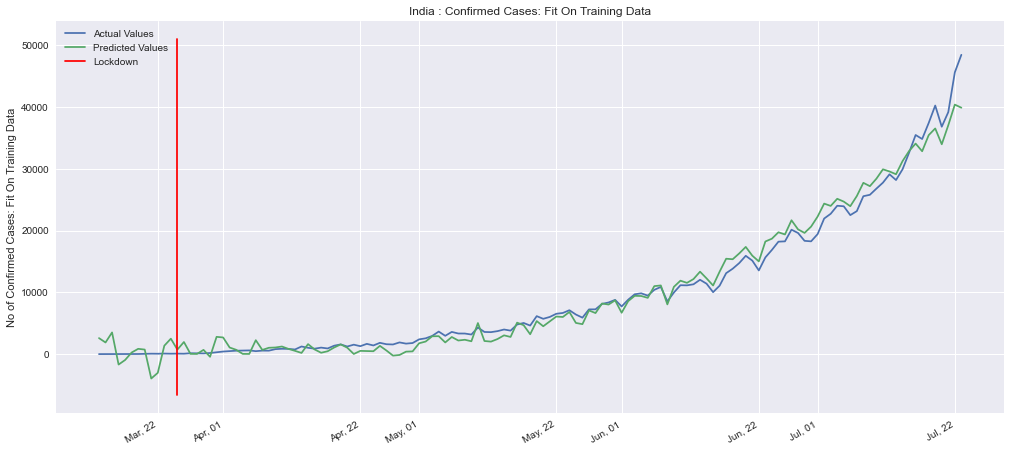

In [508]:
pipe.fit(x_train, y_train)
predictions_train = pipe.predict(x_train)
predictions_test = pipe.predict(x_test)
plot_actual_predicted('India', 'Confirmed Cases: Fit On Training Data',
                      y_train, predictions_train, show_lockdown= True, start_date='2020-03-13')

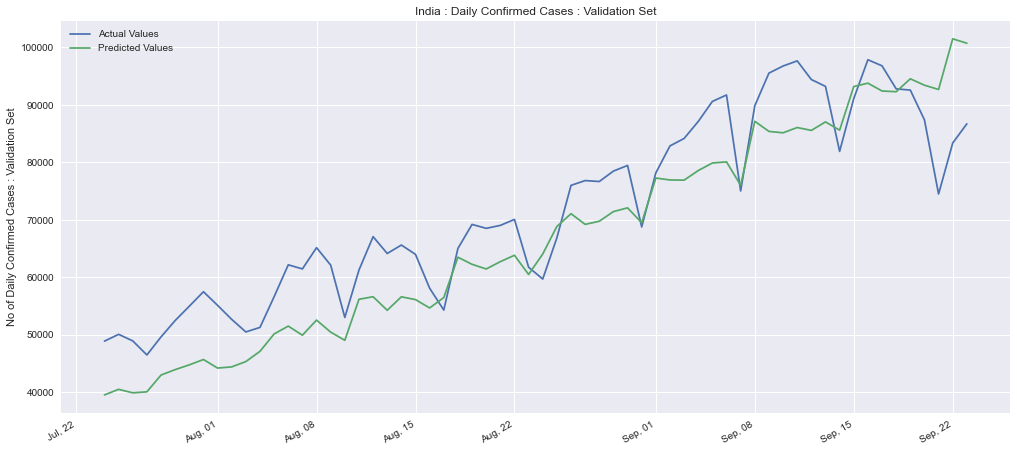

In [509]:
plot_actual_predicted('India', 'Daily Confirmed Cases : Validation Set', y_test,
                      predictions_test, show_lockdown= False,
                      start_date = y_test.index.date.min().strftime('%Y-%m-%d'))

## Forecast/Predictions

In [510]:
x_pre['Day_week'] = x_pre.index.weekday.values
pipe.fit(x, y)
predictions_z = pipe.predict(x_pre)
x_pre['Predicted_Daily_confirmed'] = predictions_z
# Total Confirmed Cases on the previous day - india_data.iloc[-1,4]
x_pre['Predicted_Total_confirmed'] = x_pre.Predicted_Daily_confirmed.copy()
x_pre.Predicted_Total_confirmed.iloc[0] = x_pre.Predicted_Daily_confirmed.iloc[0] + india_data.iloc[-1,4]
x_pre.Predicted_Total_confirmed = x_pre.Predicted_Total_confirmed.cumsum()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1993879472.6017845, tolerance: 194198180.55200002

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [511]:
# Saving Predictions
filename = 'Predictions_' + x_pre.index.min().strftime('%Y-%m-%d') + '_' + \
    x_pre.index.max().strftime('%Y-%m-%d')
x_pre.to_csv('Data/Predictions/'+ filename + '.csv')

In [512]:
pd.options.plotting.backend = "plotly"
fig = x_pre['Predicted_Daily_confirmed'].plot(title='Predicted Daily Cases: India')
fig.update_layout(yaxis=dict(title='Number of Cases'),
                  legend_title_text='Daily Predictions', legend=dict(x=.85, y=1.15),
                 xaxis = dict(title = 'Date'))

In [513]:
pd.options.plotting.backend = "plotly"
fig = x_pre['Predicted_Total_confirmed'].plot(title='Predicted Cumulative Cases: India')
fig.update_layout(yaxis=dict(title='Number of Cases'),
                  legend_title_text='Total Cases Predictions', legend=dict(x=.85, y=1.15),
                 xaxis = dict(title = 'Date'))

In [514]:
# Feature Importance 
feat_imp = pd.DataFrame(index = pipe['poly'].get_feature_names(x_pre.columns),
             data = pipe['scale'].inverse_transform(pipe['rid_reg'].coef_))
feat_imp.sort_values(by = 0, ascending=False)[:5]

0
Days_since_03_12^2             4.602637e+08
Days_since_03_12 GrowthRatio   1.276784e+06
Days_since_03_12 GrowthFactor  8.162368e+05
Days_since_03_12 Day_week      7.893835e+05
Day_week                       1.762640e+04

### Comparing Predictions with Actual Cases

In [348]:
def compare_preds(preds_df):
    """Checks Predicted values against actual number of cases
    using API parsing script. 
    """
    temp = make_dataframe()
    comp = preds_df.join(temp, on=None, how='left')
    pd.options.plotting.backend = "plotly"
    fig = comp[['Predicted_Daily_confirmed', 'DailyConfirmed']].plot(
        title='Comparing Predicted Daily Cases: India')
    fig.update_layout(yaxis=dict(title='Number of Cases'),
                      legend_title_text='Daily Predictions', legend=dict(x=.85, y=1.15),
                      xaxis=dict(title='Date'))

    # Model Perfomance/Metrics
    r2 = r2_score(comp['DailyConfirmed'].dropna(
    ), comp['Predicted_Daily_confirmed'][:len(comp['DailyConfirmed'].dropna())])
    mse = mean_squared_error(comp['DailyConfirmed'].dropna(
    ), comp['Predicted_Daily_confirmed'][:len(comp['DailyConfirmed'].dropna())])
    print(f'Model Performance – R^2: {r2} \nMSE: {mse}')

    return fig

In [349]:
# Loading Predictions if not in memory 
from Data.india_API_data.Covid19_india_org_api import make_dataframe
x_pre_saved = pd.read_csv('Data/Predictions/Predictions_2020-09-24_2020-10-25.csv', index_col= 0)

In [350]:
compare_preds(x_pre_saved)

Model Performance – R^2: -15.33083334033822 
MSE: 624650285.755088


# State-Wise Analysis
To DO:
1. Got which states have the most cases in the last week and plotted stats.(Done)
2. Fix axis label, multiple legends showing up.
1. Which state is doing the worst by comparing the growth factor(overall or last 10 days ?)
2. In which states is the situation getting worst. Compare last 10 days vs mean GF.
3. In which states has the situation improved the most. Compare last 10 days vs mean GF.

In [335]:
from Data_Pipeline.Covid19_india_org_api import make_state_dataframe
state_data = make_state_dataframe()

ImportError: cannot import name 'make_state_dataframe'

In [150]:
def growth_factor(confirmed):
    confirmed_nminus1 = confirmed.shift(1, axis=0)
    confirmed_nminus2 = confirmed.shift(2, axis=0)
    return ((confirmed - confirmed_nminus1)/(confirmed_nminus1 - confirmed_nminus2))

#### States with Absolute Most number of Confirmed Cases the Previous week

In [162]:
def sharpest_inc_state(data):
    # Group by week and sum, then find which state had the sharpest increase. 
    week_state = data.groupby(data.index.week).sum()
    week_state.rename_axis(index='Week', inplace = True)
    # 10 Worst hit states
    state_list = []
    for item in week_state.sort_values(by = week_state.index[-2], axis =1, ascending=False).columns :
        if item[1] == 'Confirmed' and item[0]!='Total':
            state_list.append(item[0])
    return state_list

In [165]:
sharpest_inc_state(state_data)[:10]

['Maharashtra',
 'Andhra Pradesh',
 'Karnataka',
 'Tamil Nadu',
 'Uttar Pradesh',
 'Odisha',
 'West Bengal',
 'Telangana',
 'Kerala',
 'Assam']

In [154]:
from plotly.subplots import make_subplots
#import plotly.graph_objects as go

In [155]:
def state_plots(state_series, state_name):
    pd.options.plotting.backend = 'plotly'
    # Creating subplots
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=(f"Daily Trends", f"7-Day Moving Average",
                                        f"Cumulative Cases", f"Growth Factor 7-Day Moving Average"),
                        vertical_spacing=.1, )
    # 1. Daily Trends
    fig_1 = state_series.plot()
    # adding figure to subplot
    fig.append_trace(fig_1['data'][0], 1, 1)
    fig.append_trace(fig_1['data'][1], 1, 1)
    fig.append_trace(fig_1['data'][2], 1, 1)

    # 2. Weekly Moving Average
    fig_2 = state_series.rolling(window=7).mean().plot()
    # removing redundant legends
    fig_2['data'][0].showlegend = False
    fig_2['data'][1].showlegend = False
    fig_2['data'][2].showlegend = False

    fig.append_trace(fig_2['data'][0], 1, 2)
    fig.append_trace(fig_2['data'][1], 1, 2)
    fig.append_trace(fig_2['data'][2], 1, 2)

    # 3. Cumulative Cases
    fig_3 = state_series.cumsum().plot()

    fig_3['data'][0].showlegend = False
    fig_3['data'][1].showlegend = False
    fig_3['data'][2].showlegend = False

    fig.append_trace(fig_3['data'][0], 2, 1)
    fig.append_trace(fig_3['data'][1], 2, 1)
    fig.append_trace(fig_3['data'][2], 2, 1)

    # 4. Weekly rolling growth factor
    gf_df = growth_factor(state_series['Confirmed'].cumsum())
    gf_df.rename(index='Growth Factor', inplace=True)
    fig_4 = gf_df.rolling(window=7).mean().plot()
    fig_4['data'][0].line['color'] = "black"
    fig.append_trace(fig_4['data'][0], 2, 2)

    # Axis Titles
    fig.update_yaxes(title_text="Cases", row=1, col=1)
    fig.update_yaxes(title_text="Cases", row=1, col=2)
    fig.update_yaxes(title_text="Cases", row=2, col=1)
    fig.update_yaxes(title_text="Growth Factor", row=2, col=2)

    # figure specs.
    fig.update_layout(height=700, showlegend=True,
                      title_text=f"{state_name} Statistics")

    return fig

### Maharashtra

In [156]:
state_plots(state_data['Maharashtra'], 'Maharashtra')

In [157]:
state_plots(state_data['Delhi'], 'Delhi')

In [158]:
state_plots(state_data['Tamil Nadu'], 'Tamil Nadu')

In [159]:
state_plots(state_data['Karnataka'], 'Karnataka')

In [256]:
state_plots(state_data['Andhra Pradesh'], 'Andhra Pradesh')

In [257]:
state_plots(state_data['Uttar Pradesh'], 'Uttar Pradesh')

In [258]:
state_plots(state_data['West Bengal'], 'West Bengal')

In [259]:
state_plots(state_data['Gujarat'], 'Gujarat')

In [23]:
# Last 10 days growth Factor mean 
delhi_gf[-10:].mean()

NameError: name 'delhi_gf' is not defined

#### Hospital Analysis

In [2]:
gov_hosp = pd.read_excel('Data/covid-19-raw-Private Hospitals (Government Quota Covid Beds).xlsx', header=1, index_col='Name of facility')

In [3]:
import plotly.express as px

In [4]:
gov_hosp.head(2)

#  Gen  HDU  ICU  ICU                 Ventl  Total  Gen.1  \
Name of facility                                                                
Aaxis Hospital      1   22    2    0                          1     25      2   
ACE Suhas Hospital  2   22    0    2                          1     25      2   

                    HDU.1  ICU.1  ICU                 Ventl.1  Total.1  Gen.2  \
Name of facility                                                                
Aaxis Hospital          0      0                            0        2     20   
ACE Suhas Hospital      0      2                            1        5     20   

                    HDU.2  ICU.2  ICU                 Ventl.2  Total.2  
Name of facility                                                        
Aaxis Hospital          2      0                            1       23  
ACE Suhas Hospital      0      0                            0       20

In [5]:
gov_hosp.columns

Index(['#', 'Gen', 'HDU', 'ICU', 'ICU                 Ventl', 'Total', 'Gen.1',
       'HDU.1', 'ICU.1', 'ICU                 Ventl.1', 'Total.1', 'Gen.2',
       'HDU.2', 'ICU.2', 'ICU                 Ventl.2', 'Total.2'],
      dtype='object')

In [6]:
gov_hosp.reset_index(inplace=True)

In [7]:
data = gov_hosp.groupby(['Name of facility'])['ICU'].sum()

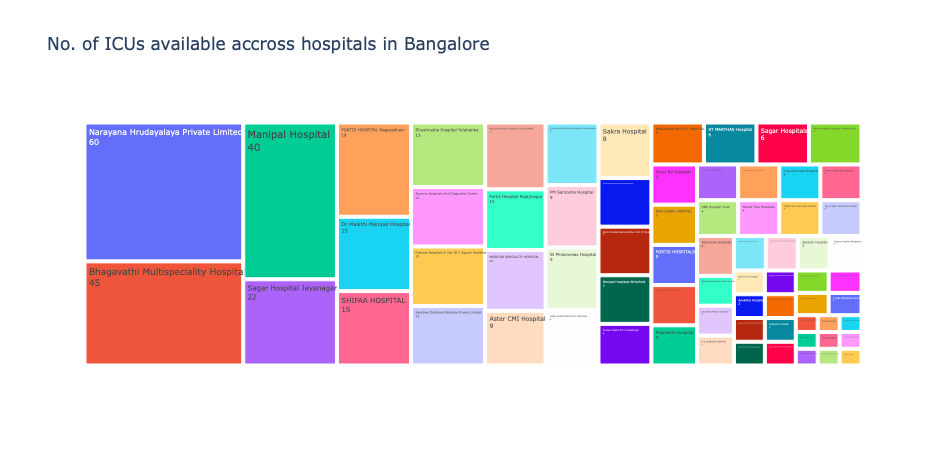

In [12]:
fig = px.treemap(data_frame=gov_hosp, path = ['Name of facility'], values='ICU',
                 title = 'No. of ICUs available accross hospitals in Bangalore')
fig.data[0].textinfo = 'label+text+value'
fig.write_image("fig1.png", width=1200, height=700, scale=2)
fig.show()

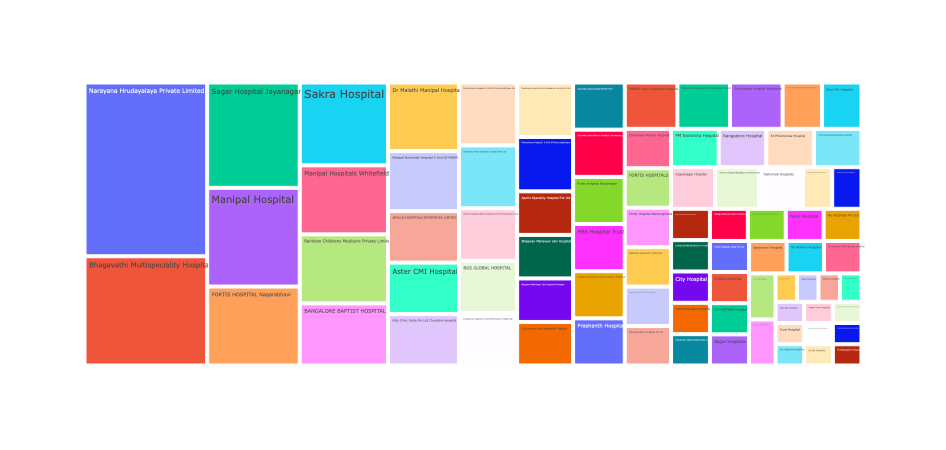

In [38]:
fig = px.treemap(data_frame=gov_hosp, path = ['Name of facility'], values='ICU                 Ventl')

fig.show()

# Time Series Forecasting Approach
Modularise code. <br>
Write a brief analysis, what stuff means, limitations of approach, where this works ?

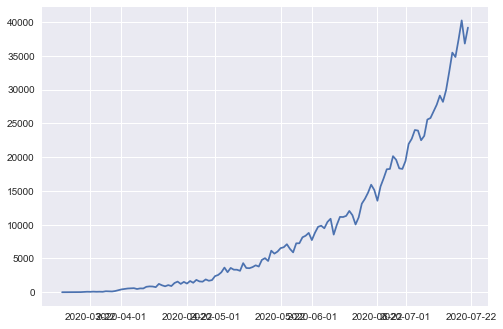

In [317]:
# Since Atleast a 100 new cases per day
# Strong Trend(It is well Understood it has exponential growth in initial stages)
# Difficult to imagine how this'll be stationary
ts = india_data.DailyConfirmed[43:]
plt.plot(ts)
plt.show()

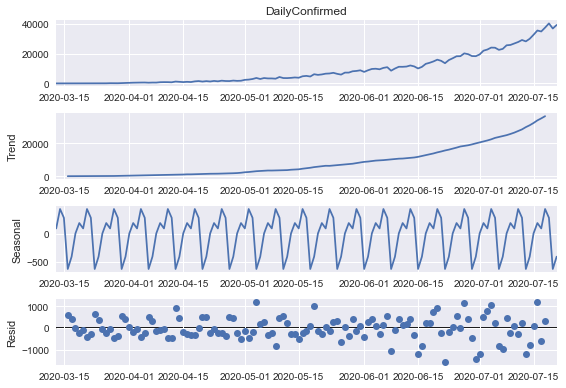

In [318]:
# Decomposing into components
res = seasonal.seasonal_decompose(ts, model='additive', period=None)
plt_season = res.plot()
# Very strong trend and weekly trend - Seems to indicate some testing convention ? less resuls/tests on the weekend

In [319]:
# Augmented Dickey Fuller test to check for unit root and stationarity
def perf_adf(ts):
    """Performs ADF test on time series and prints Results.
    """
    dftest = stattools.adfuller(ts, maxlag=None, autolag='AIC')
    df_result = pd.Series(dftest[:4], index = ['Test- Stat', 'P-Value', '# of Lags Used', '# of Obs Used'])
    # For Critical values at diff. confidence intervals
    for key, value in dftest[4].items():
        df_result[f'Critical Value {key}'] = value
    display(df_result.head(10))

In [320]:
# No Chance of Stationarity
perf_adf(ts)

Test- Stat              4.803162
P-Value                 1.000000
# of Lags Used         13.000000
# of Obs Used         117.000000
Critical Value 1%      -3.487517
Critical Value 5%      -2.886578
Critical Value 10%     -2.580124
dtype: float64

Test- Stat              1.426325
P-Value                 0.997231
# of Lags Used         13.000000
# of Obs Used         116.000000
Critical Value 1%      -3.488022
Critical Value 5%      -2.886797
Critical Value 10%     -2.580241
dtype: float64

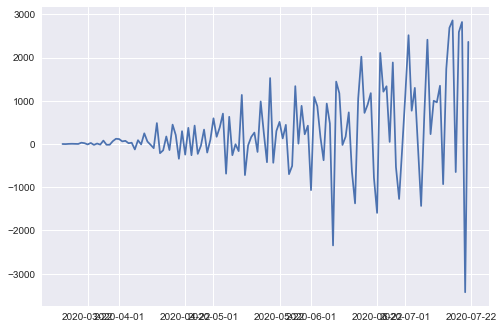

In [321]:
# 1st order difference of lag 1
plt.plot(ts.diff(1))
perf_adf(ts.diff(1).dropna())

Test- Stat             -5.184028
P-Value                 0.000009
# of Lags Used         13.000000
# of Obs Used         115.000000
Critical Value 1%      -3.488535
Critical Value 5%      -2.887020
Critical Value 10%     -2.580360
dtype: float64

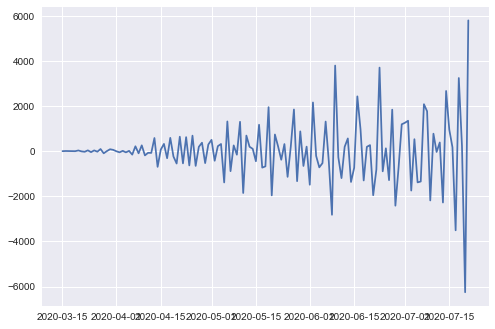

In [322]:
# Differencning by order 2 makes the time series stationary
plt.plot(ts.diff(1).diff(1))
perf_adf(ts.diff(1).diff(1).dropna())

Test- Stat             -3.009966
P-Value                 0.033974
# of Lags Used         13.000000
# of Obs Used         109.000000
Critical Value 1%      -3.491818
Critical Value 5%      -2.888444
Critical Value 10%     -2.581120
dtype: float64

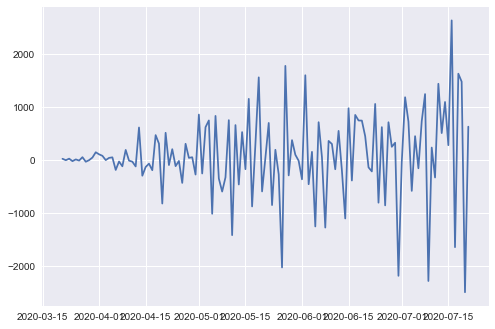

In [323]:
# Removing weekly seasonlity first and then differencing for trend does seem to make it stationary.
perf_adf(ts.diff(7).diff(1).dropna())
plt.plot(ts.diff(7).diff(1).dropna())

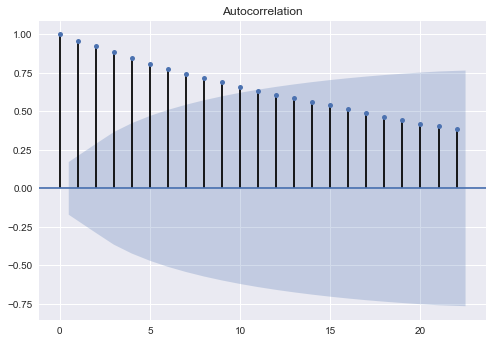

In [324]:
acf = plot_acf(ts)

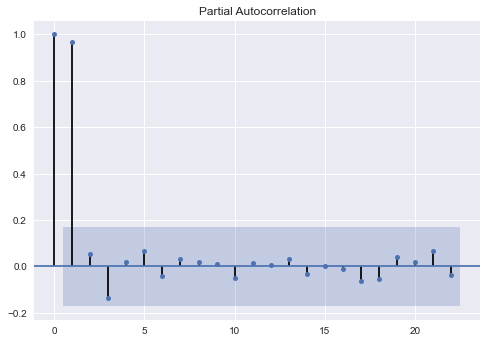

In [325]:
pacf = plot_pacf(ts)

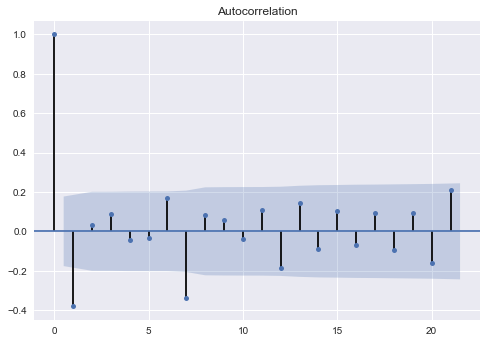

In [326]:
acf = plot_acf(ts.diff(7).diff(1).dropna())

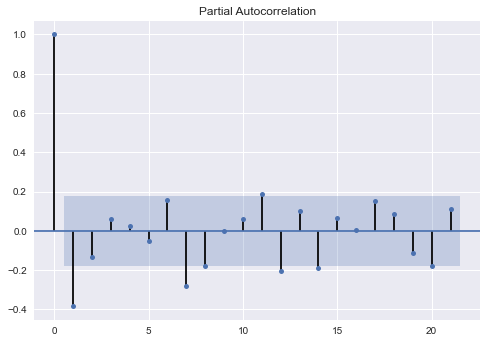

In [327]:
pacf = plot_pacf(ts.diff(7).diff(1).dropna())

### Trying Both ARIMA and SARIMA

In [328]:
ts_train = ts[:-31]
ts_test = ts[-31:]

#### ARIMA

In [329]:
# instantialing model - This has been deprecated
model = arima_model.ARIMA(ts_train, order=(2,1, 1))
# Fitting model 
res_model = model.fit( trend='nc', method='css-mle') # Returns a wrapper to result clas
# Using the evaluation metric AIC - AIC rewards goodness of fit (as assessed by the likelihood function), 
# but it also includes a penalty that is an increasing function of the number of estimated parameters.
# Lower is better.
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1557.602340985866

In [330]:
res_model.params

ar.L1.D.DailyConfirmed   -0.424175
ar.L2.D.DailyConfirmed   -0.175130
ma.L1.D.DailyConfirmed    0.339261
dtype: float64

In [331]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.DailyConfirmed   No. Observations:                   99
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -774.801
Method:                       css-mle   S.D. of innovations            606.093
Date:                Wed, 22 Jul 2020   AIC                           1557.602
Time:                        19:24:27   BIC                           1567.983
Sample:                    03-14-2020   HQIC                          1561.802
                         - 06-20-2020                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
ar.L1.D.DailyConfirmed    -0.4242      0.308     -1.375      0.169      -1.029       0.180
ar.L2.D.DailyConfirmed    -0.1751      0.101     -1.737      0.082      -0.373       0.023
ma.L1.D.DailyConfirmed     0.3393      0.301      1.127      0.260      -0.251       0.929
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2110           -2.0600j            2.3896           -0.3346
AR.2           -1.2110           +2.0600j            2.3896            0.3346
MA.1           -2.9476           +0.0000j            2.9476            0.5000
-----------------------------------------------------------------------------
"""

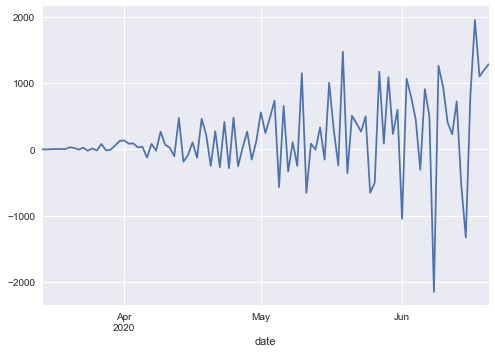

In [332]:
pd.options.plotting.backend = 'matplotlib'
res_model.resid.plot()

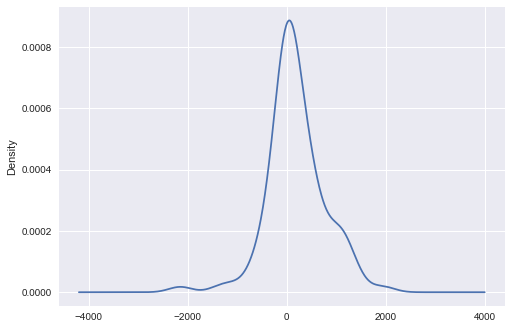

In [333]:
res_model.resid.plot(kind='kde')

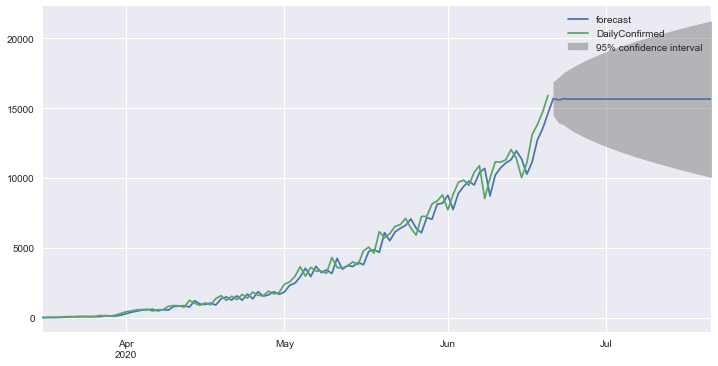

In [334]:
fig = res_model.plot_predict(3, ts_test.index.date[-1])
fig.set_figwidth(12)
fig.set_figheight(6)
plt.show()

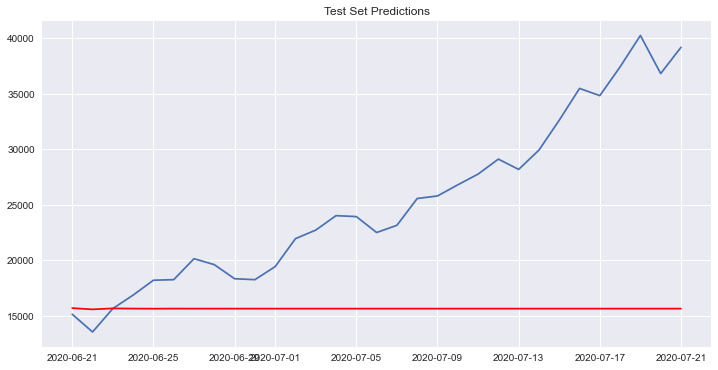

In [335]:
plt.figure(figsize=(12,6))
plt.plot(ts_test)
plt.plot_date(ts_test.index.date,res_model.forecast(len(ts_test))[0], 'r-')
plt.title('Test Set Predictions')
plt.show()

In [336]:
rmse =sqrt(mean_squared_error(ts_test, res_model.forecast(len(ts_test))[0]))
print(rmse)

12121.757671761037


#### SARIMA 

In [337]:
# instantialing model - This has been deprecated
model = sarimax.SARIMAX(ts_train, trend='n', order=(1,1,0), seasonal_order=(0,1,1,7))
# Fitting model 
res_model = model.fit() # Returns a wrapper to result clas
# Using the evaluation metric AIC - AIC rewards goodness of fit (as assessed by the likelihood function), 
# but it also includes a penalty that is an increasing function of the number of estimated parameters.
# Lower is better.
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1411.5728990859805

In [338]:
res_model.params

ar.L1          -0.348877
ma.S.L7        -0.470088
sigma2     249414.797147
dtype: float64

In [339]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DailyConfirmed   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -702.786
Date:                             Wed, 22 Jul 2020   AIC                           1411.573
Time:                                     19:24:48   BIC                           1419.138
Sample:                                 03-13-2020   HQIC                          1414.626
                                      - 06-20-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3489      0.094     -3.711      0.000      -0.533      -0.165
ma.S.L7       -0.4701      0.078     -6.062      0.000      -0.622      -0.318
sigma2      2.494e+05   2.78e+04      8.978      0.000    1.95e+05    3.04e+05
===================================================================================
Ljung-Box (Q):                       57.01   Jarque-Bera (JB):                12.30
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              13.28   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

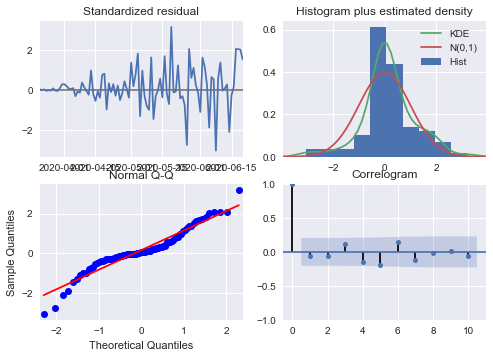

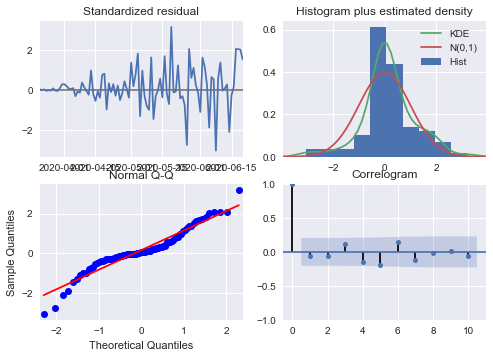

In [340]:
res_model.plot_diagnostics()

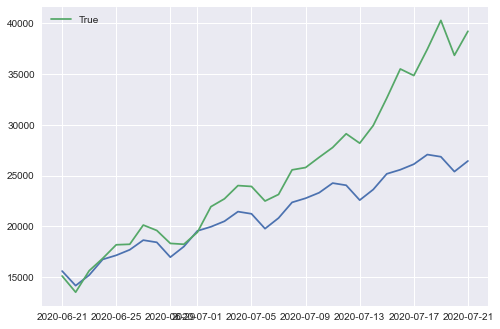

In [342]:
plt.plot(res_model.forecast(len(ts_test)))
plt.plot(ts_test, label = 'True')
plt.legend()
plt.show()

In [343]:
rmse =sqrt(mean_squared_error(ts_test, res_model.forecast(len(ts_test))))
print(rmse)

5652.591248753712


#### Training on Entire Data and Forecasting for Next Month

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



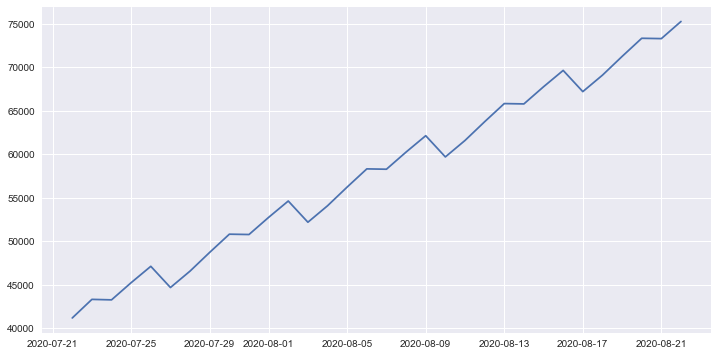

In [357]:
model = sarimax.SARIMAX(ts, trend='n', order=(1,1,0), seasonal_order=(0,1,1,7))
# Fitting model 
res_model = model.fit() # Returns a wrapper to result clas
plt.figure(figsize=(12,6))
plt.plot(res_model.predict(start =len(ts_train + ts_test), end = len(ts_train + ts_test)+31))

### Comparing Lasso Regression and SARIMA

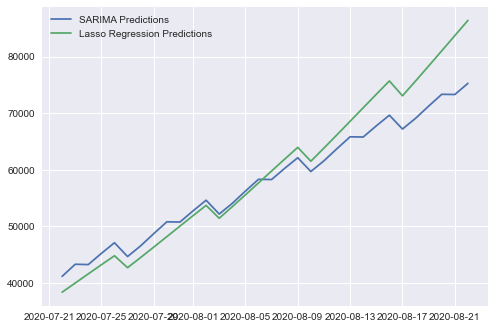

In [358]:
plt.plot(res_model.predict(start =len(ts_train + ts_test), end = len(ts_train + ts_test)+31), label = 'SARIMA Predictions')
plt.plot(x_pre.Predicted_Daily_confirmed, label = 'Lasso Regression Predictions')
plt.legend()
plt.show()

### Tree Based Regression Model - XGBoost Regressor

In [347]:
# Days since widespread data Availibity. 03-12

india_data['Days'] = 0
# -2 due to the fact that last two growth facotrs and ratios are predicted, would be leakage, dropping last two points
x = india_data[['Days','GrowthFactor', 'GrowthRatio']][43:]
x['Days'] = np.arange(1, len(india_data[43:])+1)
x['Day_week'] = x.index.dayofweek.values
y = india_data['DailyConfirmed'][43:]
# Not Shuffling time-Series Data.
x_train, x_test, y_train, y_test = x[:-62], x[-62:], y[:-62], y[-62:]

In [348]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [349]:
x_train_tree = create_features(x_train.drop(['Day_week'], axis = 1))

In [350]:
x_test_tree = create_features(x_test.drop(['Day_week'], axis = 1))

In [351]:
xgb_reg = XGBRegressor(n_estimators = 1000,learning_rate=.3,max_depth=6,
                       n_jobs = -1, objective='reg:squarederror', eval_metric= 'rmse')

In [352]:
xgb_reg.fit(x_train_tree.values, y_train.values, 
             early_stopping_rounds=10, 
             eval_set=[(x_test_tree.values, y_test.values)],
             verbose=True)

[0]	validation_0-rmse:18922.05664
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:18211.79492
[2]	validation_0-rmse:17507.63281
[3]	validation_0-rmse:17067.29297
[4]	validation_0-rmse:16661.04297
[5]	validation_0-rmse:16359.49316
[6]	validation_0-rmse:16072.34180
[7]	validation_0-rmse:15844.62012
[8]	validation_0-rmse:15693.28809
[9]	validation_0-rmse:15547.08594
[10]	validation_0-rmse:15430.72070
[11]	validation_0-rmse:15356.05664
[12]	validation_0-rmse:15280.31543
[13]	validation_0-rmse:15219.89356
[14]	validation_0-rmse:15194.22754
[15]	validation_0-rmse:15174.62109
[16]	validation_0-rmse:15158.76465
[17]	validation_0-rmse:15144.03613
[18]	validation_0-rmse:15131.54492
[19]	validation_0-rmse:15124.00195
[20]	validation_0-rmse:15116.01172
[21]	validation_0-rmse:15110.81250
[22]	validation_0-rmse:15106.39648
[23]	validation_0-rmse:15102.64453
[24]	validation_0-rmse:15099.45898
[25]	validation_0-rmse:15096.75293
[26]	validation_0-rmse:15094.45312


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

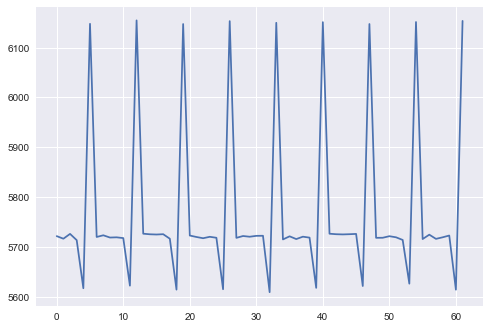

In [353]:
plt.plot(xgb_reg.predict(x_test_tree.values))